# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need? in thin the
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

### Download missing libraries
Comment in the following two lines in case some of the libraries cannot be imported. Please restart the kernel after download+upgrade has successfully finished

In [1]:
### Download libraries
%pip install uproot 
%pip install awkward 
%pip install mplhep 
%pip install numpy 
%pip install matplotlib 
%pip install scipy

### Upgrade libraries to latest version
%pip install uproot awkward mplhep numpy matplotlib scipy --upgrade

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Requirement already up-to-date: uproot in /projects/63454346-ff20-4eeb-9bfe-13b80b7728fd/.local/lib/python3.8/site-packages (4.0.6)


Requirement already up-to-date: awkward in /projects/63454346-ff20-4eeb-9bfe-13b80b7728fd/.local/lib/python3.8/site-packages (1.1.2)


Requirement already up-to-date: mplhep in /projects/63454346-ff20-4eeb-9bfe-13b80b7728fd/.local/lib/python3.8/site-packages (0.2.18)


Requirement already up-to-date: numpy in /projects/63454346-ff20-4eeb-9bfe-13b80b7728fd/.local/lib/python3.8/site-packages (1.20.1)


Requirement already up-to-date: matplotlib in /projects/63454346-ff20-4eeb-9bfe-13b80b7728fd/.local/lib/python3.8/site-packages (3.3.4)


Requirement already up-to-date: scipy in /projects/63454346-ff20-4eeb-9bfe-13b80b7728fd/.local/lib/python3.8/site-packages (1.6.1)


Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [90]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

## *Example*: Reading a ROOT.TTree and plotting a variable with a cut

We will open data and Monte Carlo samples using **uproot**. Uproot is a reader and a writer of the ROOT file format using only Python and Numpy. Unlike PyROOT and root_numpy, uproot does not depend on C++ ROOT so that no local compilation of the ROOT libraries is needed to access the data.

You can find more info on uproot following the references:
* Github repo: https://github.com/scikit-hep/uproot4
* Tutorial: https://masonproffitt.github.io/uproot-tutorial/
* Video tutorial on uproot and awkward arrays:  https://www.youtube.com/embed/ea-zYLQBS4U 

First, let's specify the folder path for both data and Monte Carlo (MC) samples

In [227]:
## Take folder with samples from Google Drive
#%pip install google-colab
#from google.colab import drive
#import os
#samplefolder = drive.mount('samples')
#path_data = 'opal_data/mc/'
path_mc = 'opal_data/mc/'

### Open the file introducing file path
#file = uproot.open(path_data+'daten.root')
fileee = uproot.open(path_mc+'ee.root')
filemm = uproot.open(path_mc+'mm.root')
filett = uproot.open(path_mc+'tt.root')
fileqq = uproot.open(path_mc+'qq.root')

files = [fileee, filemm, filett, fileqq]

ttree_name = 'myTTree'

### Print list of 'branches' of the TTree (i.e. list of variable names)
#print(file[ttree_name].keys())

## Load branches
branchesee = files[0][ttree_name].arrays()
branchesmm = files[1][ttree_name].arrays()
branchestt = files[2][ttree_name].arrays()
branchesqq = files[3][ttree_name].arrays()


branchessum = 0




brancheses = [branchesee, branchesmm, branchestt, branchesqq, branchessum]

## Define an numpy array for 'Pcharged'
var = 'Pcharged'
var2 = 'E_lep'
#pcharee = ak.to_numpy(branchesee[var]) # See Docu (https://awkward-array.org/how-to-convert-numpy.html) for more conversions

var = ['Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'E_lep', 'cos_thru', 'cos_thet', 'run', 'event']

pchares = [0] * 5
nchares = [0] * 5
eecal = [0] * 5
ehcal = [0] * 5
elep = [0] * 5
costhru = [0] * 5
costhet = [0] * 5

run = [0] * 5
event = [0] * 5
i = 0
while i < 4:
    nchares[i] = ak.to_numpy(brancheses[i][var[0]])
    pchares[i] = ak.to_numpy(brancheses[i][var[1]])
    eecal[i] = ak.to_numpy(brancheses[i][var[2]])
    ehcal[i] = ak.to_numpy(brancheses[i][var[3]])
    elep[i] = ak.to_numpy(brancheses[i][var[4]])
    costhru[i] = ak.to_numpy(brancheses[i][var[5]])
    costhet[i] = ak.to_numpy(brancheses[i][var[6]])
    run[i] = ak.to_numpy(brancheses[i][var[7]])
    event[i] = ak.to_numpy(brancheses[i][var[8]])
    i += 1

#nchares[4] = np.concatenate((nchares[0], nchares[1], nchares[2], nchares[3]),axis=None)
nchares[4] = np.concatenate((nchares[:4]),axis=None)
pchares[4] = np.concatenate((pchares[:4]),axis=None)
eecal[4] = np.concatenate((eecal[:4]),axis=None)
ehcal[4] = np.concatenate((ehcal[:4]),axis=None)
elep[4] = np.concatenate((elep[:4]),axis=None)
costhru[4] = np.concatenate((costhru[:4]),axis=None)
costhet[4] = np.concatenate((costhet[:4]),axis=None)
run[4] = np.concatenate((run[:4]),axis=None)
event[4] = np.concatenate((event[:4]),axis=None)


brancheses[4] = ak.Array([
    {"run": run[4], "event": event[4], 'Ncharged' : nchares[4], 'Pcharged' : pchares[4], 'E_ecal' : eecal[4], 'E_hcal' : ehcal[4], 'E_lep' : elep[4], 'cos_thru' : costhru[4], 'cos_thet' : costhet[4]}
    ])

#print(brancheses[0]['run'][-1])
#E_lep = ak.to_numpy(branches[var2])

print(f"Array of type '{type(pchar)}' defined for '{var}':\n{pchar}")
print(pchar.max())

1308.0
Array of type '<class 'numpy.ndarray'>' defined for '['Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'E_lep', 'cos_thru', 'cos_thet', 'run', 'event']':
[36.15152  62.90951  66.66082  ... 65.85204  56.341167 68.896835]
45531.867


In [6]:
print(type(branches[var]))
print(type(pchar))


<class 'awkward.highlevel.Array'>
<class 'numpy.ndarray'>


The last line shows all the variables available in the TTree to carry out the experiment. The meaning of these is described in the following table

| Variable name | Description |
| --- | --- | 
| <pre>run</pre> | Run number |
| <pre>event</pre> | Event number |
| <pre>Ncharged</pre> | Number of charged tracks |
| <pre>Pcharged</pre> | Total scalar sum of track momenta |
| <pre>E_ecal</pre> | Total energy measured in the electromagnetic calorimeter |
| <pre>E_hcal</pre> | Total energy measured in the hadronic calorimete |
| <pre>E_lep</pre> | LEP beam energy (=$\sqrt{s}/2$) |
| <pre>cos_thru</pre> | cosine of the polar angle between beam axis and thrust axis |
| <pre>cos_thet</pre> | cosine of the polar angle between incoming positron and outgoing positive particle |

We proceed to plot *PCharged* for illustration.

You can find all features provided by the function *matplotlib.pyplot.hist()* in the **matplotlib documentation**: https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.hist.html

### Apply a cut

Cuts are applied by *masking* the array. This can be done as follows:

In [194]:
## Create a mask for certain selection
mymask = brancheses[4]['Ncharged'] >= 18.4
print(mymask)

## The sum of this array provides the number of events that passed this cut
#print(f"A total of '{sum(mymask)}' out of '{len(mymask)}' events passed the cut 'mymask'")

[... True, False, True, True, False, False, True, True, False, True, True, True]]


In [171]:
brancheses[4]['Ncharged']

<Array [... 16, 10, 26, 23, 16, 27, 24, 21]] type='1 * var * float64'>

### Some useful information about your selection

In [8]:
print(f"Mean of {var}: ({pchar.mean()}) {np.nanmean(pchar)}")
print(f"Standard deviation of {var}: ({pchar.std()}) {np.nanstd(pchar)}")
print(f"Minimum value of {var}: ({pchar.min()}) {np.nanmin(pchar)}")
print(f"Maximum value of {var}: ({pchar.max()}) {np.nanmax(pchar)}")

Mean of Pcharged: (55.68336486816406) 55.68336486816406
Standard deviation of Pcharged: (311.40924072265625) 311.40924072265625
Minimum value of Pcharged: (0.0) 0.0
Maximum value of Pcharged: (45531.8671875) 45531.8671875


In [22]:
E_lep

array([45.625, 45.625, 45.625, ..., 45.624, 45.624, 45.624], dtype=float32)

### Make a plot with a certain selection

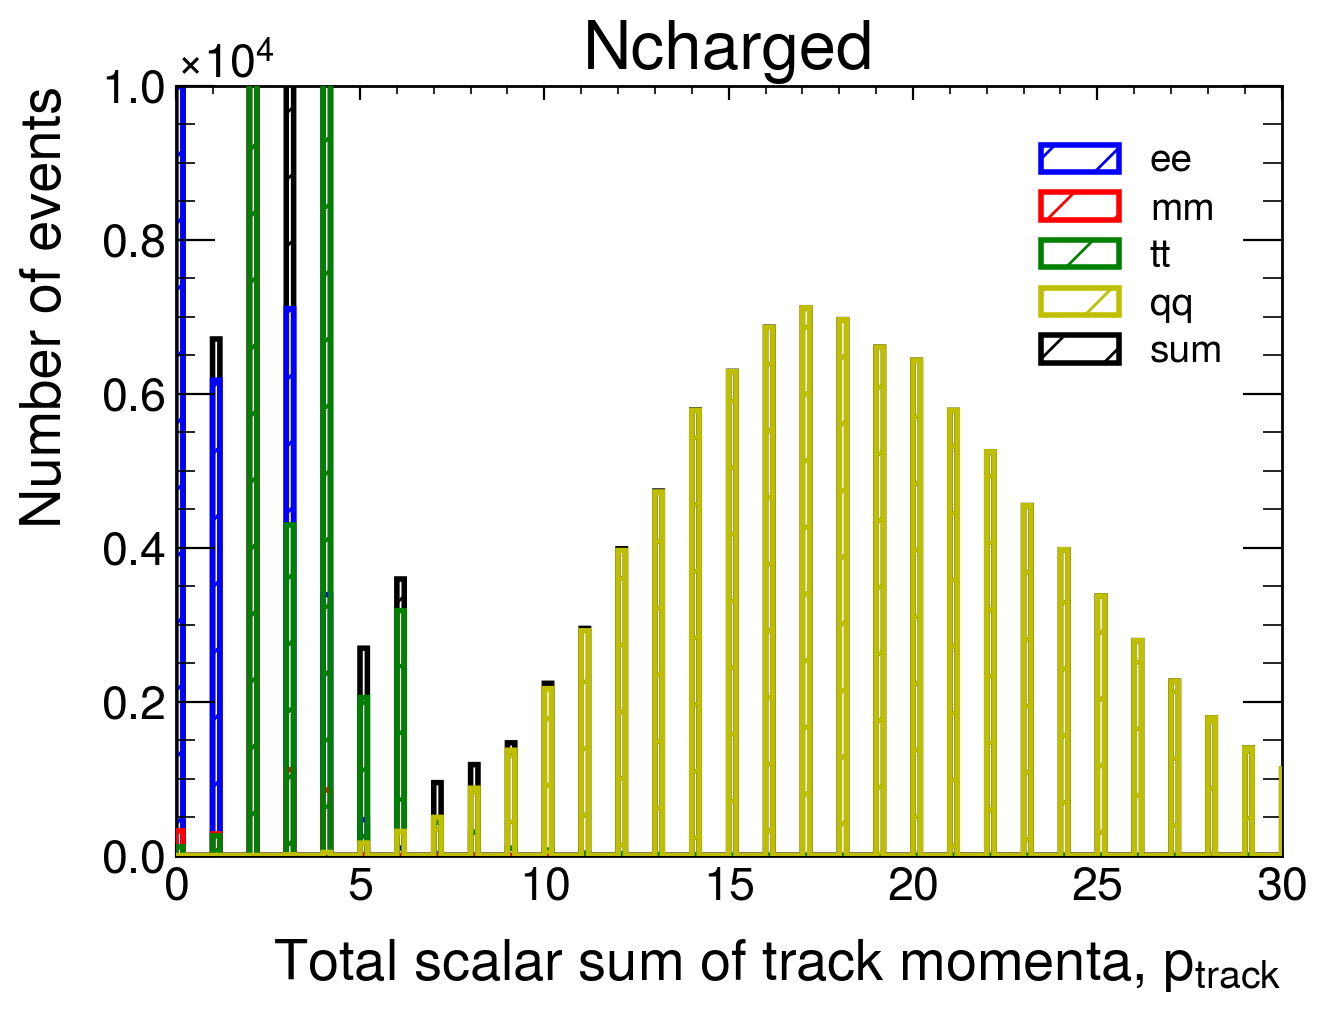

In [264]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(nchares[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='ee', zorder=2)
bin_content, bin_edges, _ = plt.hist(nchares[1], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='mm', zorder=3)
bin_content, bin_edges, _ = plt.hist(nchares[2], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='tt', zorder=4)
bin_content, bin_edges, _ = plt.hist(nchares[3], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='qq', zorder=5)
bin_content, bin_edges, _ = plt.hist(nchares[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[0])
plt.xlim(0.,30)
plt.ylim(0,10e3)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

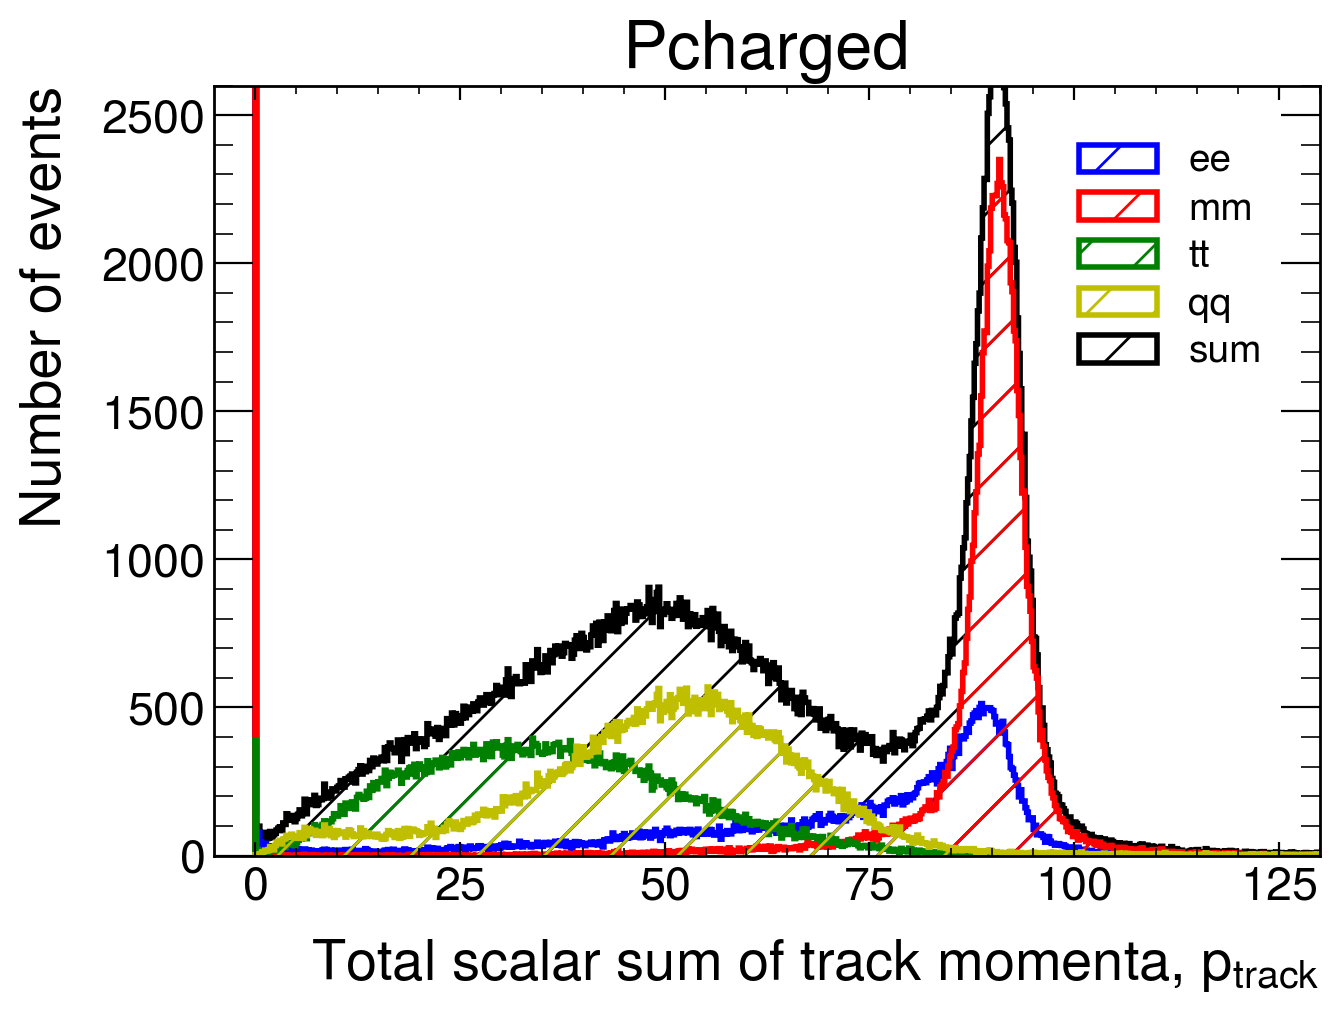

In [219]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(pchares[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='ee')
bin_content, bin_edges, _ = plt.hist(pchares[1], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='mm')
bin_content, bin_edges, _ = plt.hist(pchares[2], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='tt')
bin_content, bin_edges, _ = plt.hist(pchares[3], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='qq')
bin_content, bin_edges, _ = plt.hist(pchares[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[1])
plt.xlim(-5,130.)
plt.ylim(0,2.6e3)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

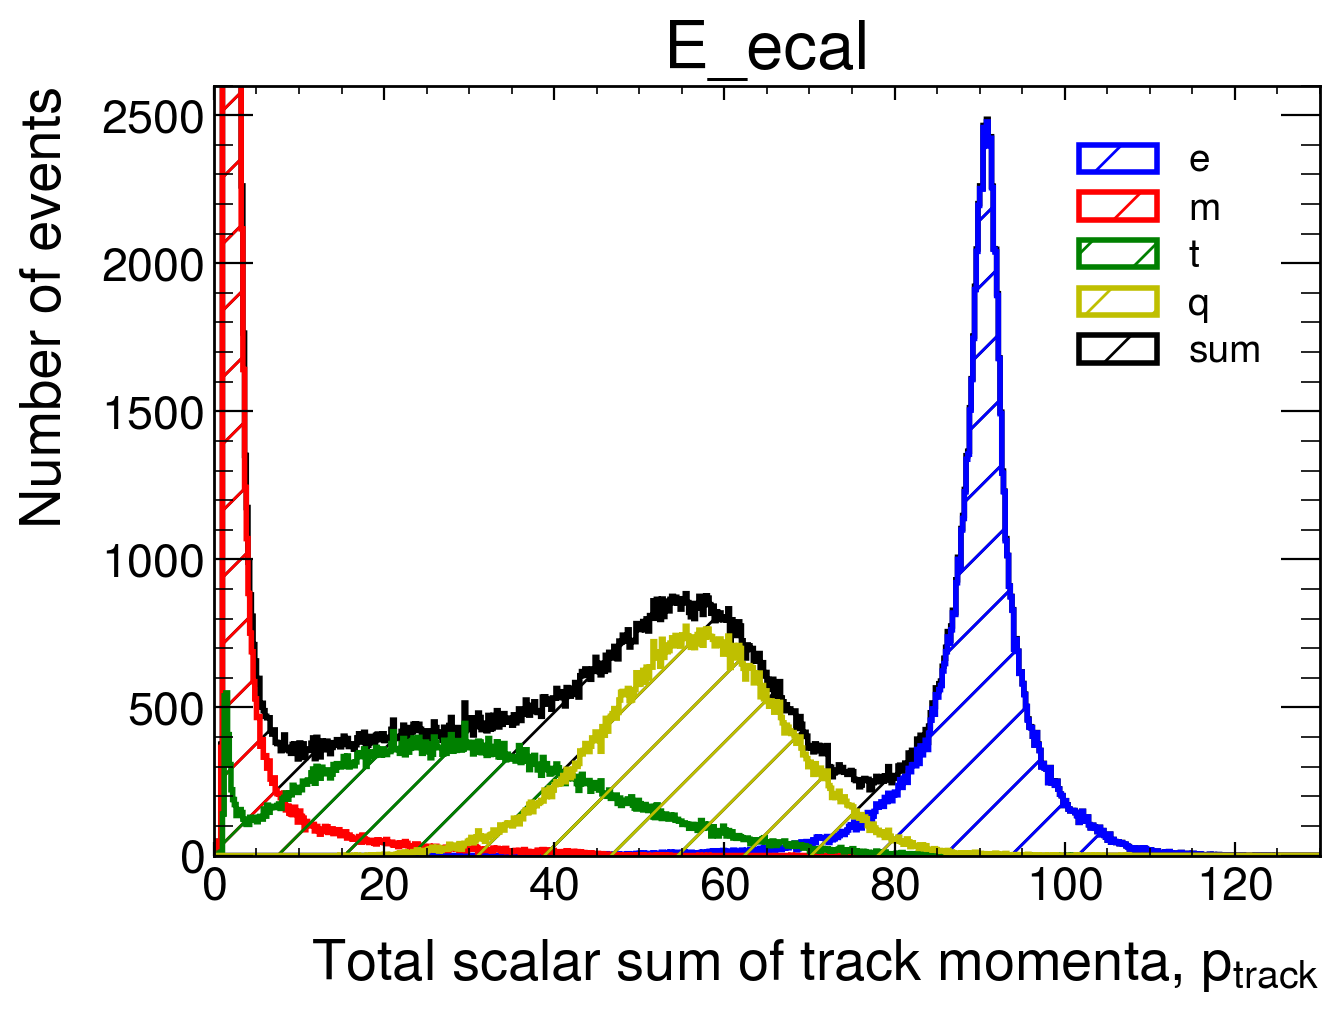

In [116]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(eecal[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(eecal[1], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(eecal[2], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(eecal[3], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')
bin_content, bin_edges, _ = plt.hist(eecal[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[2])
plt.xlim(0.,130.)
plt.ylim(0,2.6e3)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

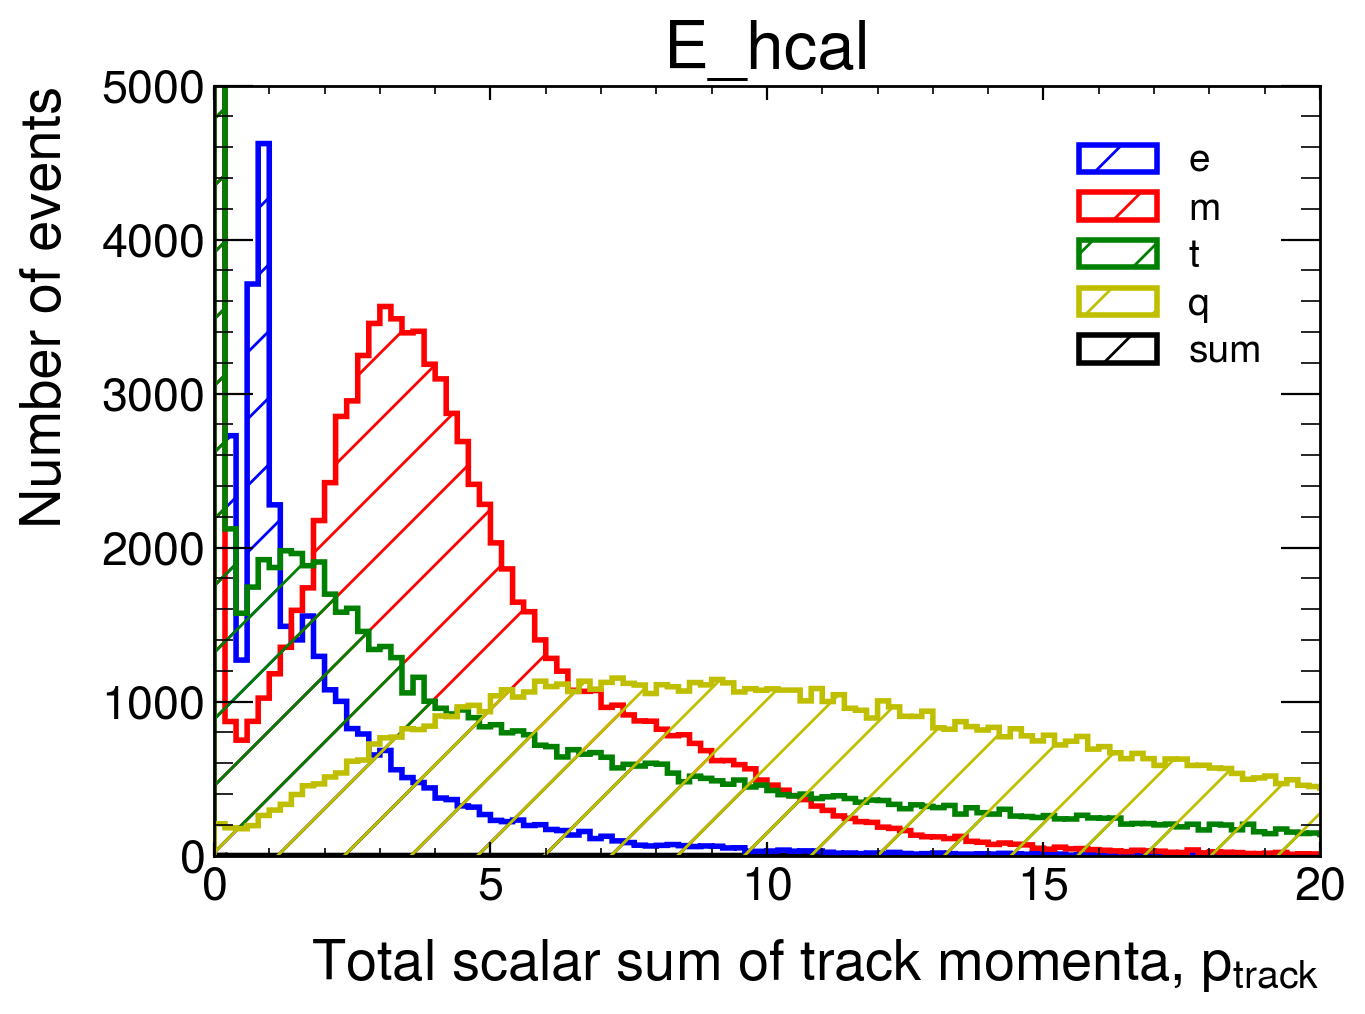

In [117]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(ehcal[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(ehcal[1], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(ehcal[2], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(ehcal[3], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')
bin_content, bin_edges, _ = plt.hist(ehcal[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[3])
plt.xlim(0.,20.)
plt.ylim(0,5e3)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1705e+04, 2.9300e+02,
        1.7200e+02, 1.4500e+02, 1.3100e+02, 1.1800e+02, 1.0400e+02,
        1.0300e+02, 8.3000e+01, 1.1500e+02, 1.0600e+02, 9.2000e+01,
        1.0500e+02, 1.0100e+02, 1.0200e+02, 1.0400e+02, 1.5200e+02,
        1.2000e+02, 1.6800e+02, 1.5800e+02, 1.8200e+02, 1.8700e+02,
        1.8200e+02, 2.2500e+02, 2.2600e+02, 2.3800e+02, 2.3800e+02,
        2.9300e+02, 2.6500e+02, 2.6100e+02, 2.5600e+02, 2.8300e+02,
        3.3300e+02, 4.1000e+02, 4.4900e+02, 4.6600e+02, 4.8900e+02,
        4.8400e+02, 5.1700e+02, 5.6700e+02, 5.1400e+02, 5.2400e+02,
        5.0500e+02, 5.3500e+02, 6.4100e+02, 6.2100e+02, 6.6400e+02,
        6.2300e+02, 6.4000e+02, 6.6700e+02, 6.9900e+02, 8.3300e+02,
        8.4500e+02, 8.3300e+02, 9.3000e+02, 1.0040e+03, 1.0600e+03,
        1.1050e+03, 1.2530e+03, 1.2610e+03, 1.4820e+03, 1.7180e+03,
        1.8910e+03, 2.1720e+03, 2.5490e+03, 3.0670e+03, 3.3430e+03,
        3.1660e+03, 2.6910e+03, 1.7240e+03, 1.03

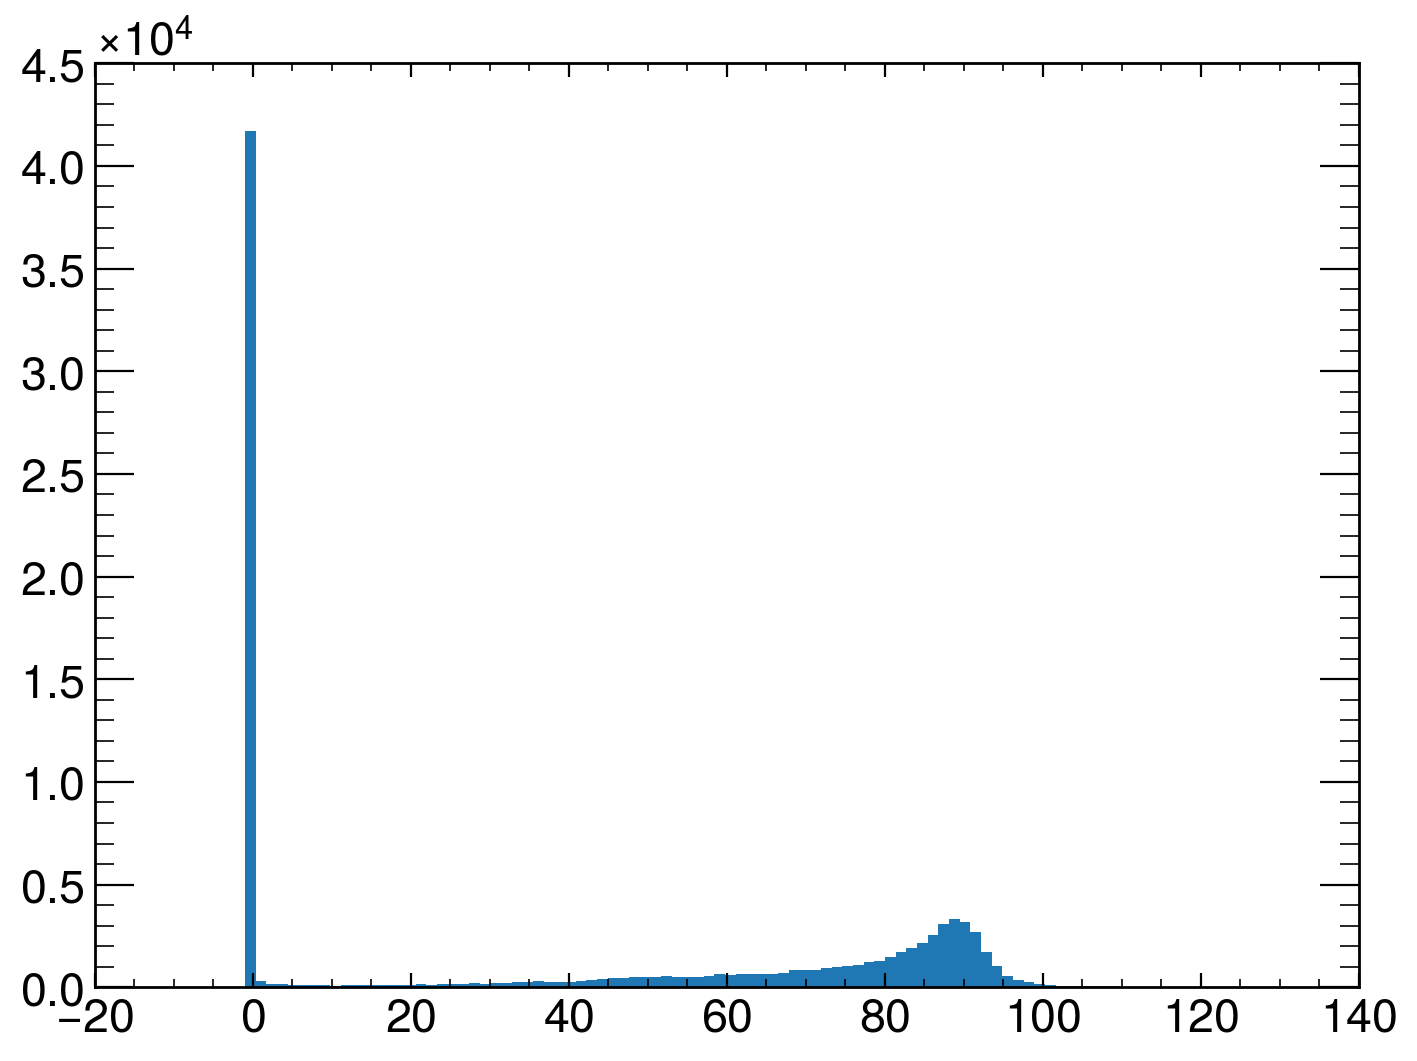

In [185]:
plt.hist(pchares[0],bins = 100, range = (-5,130))

In [149]:
eecal[0]

array([88.92962 , 90.303406, 89.63274 , ..., 96.30155 , 92.580894,
       89.81569 ], dtype=float32)

Text(0, 1, 'pchares')

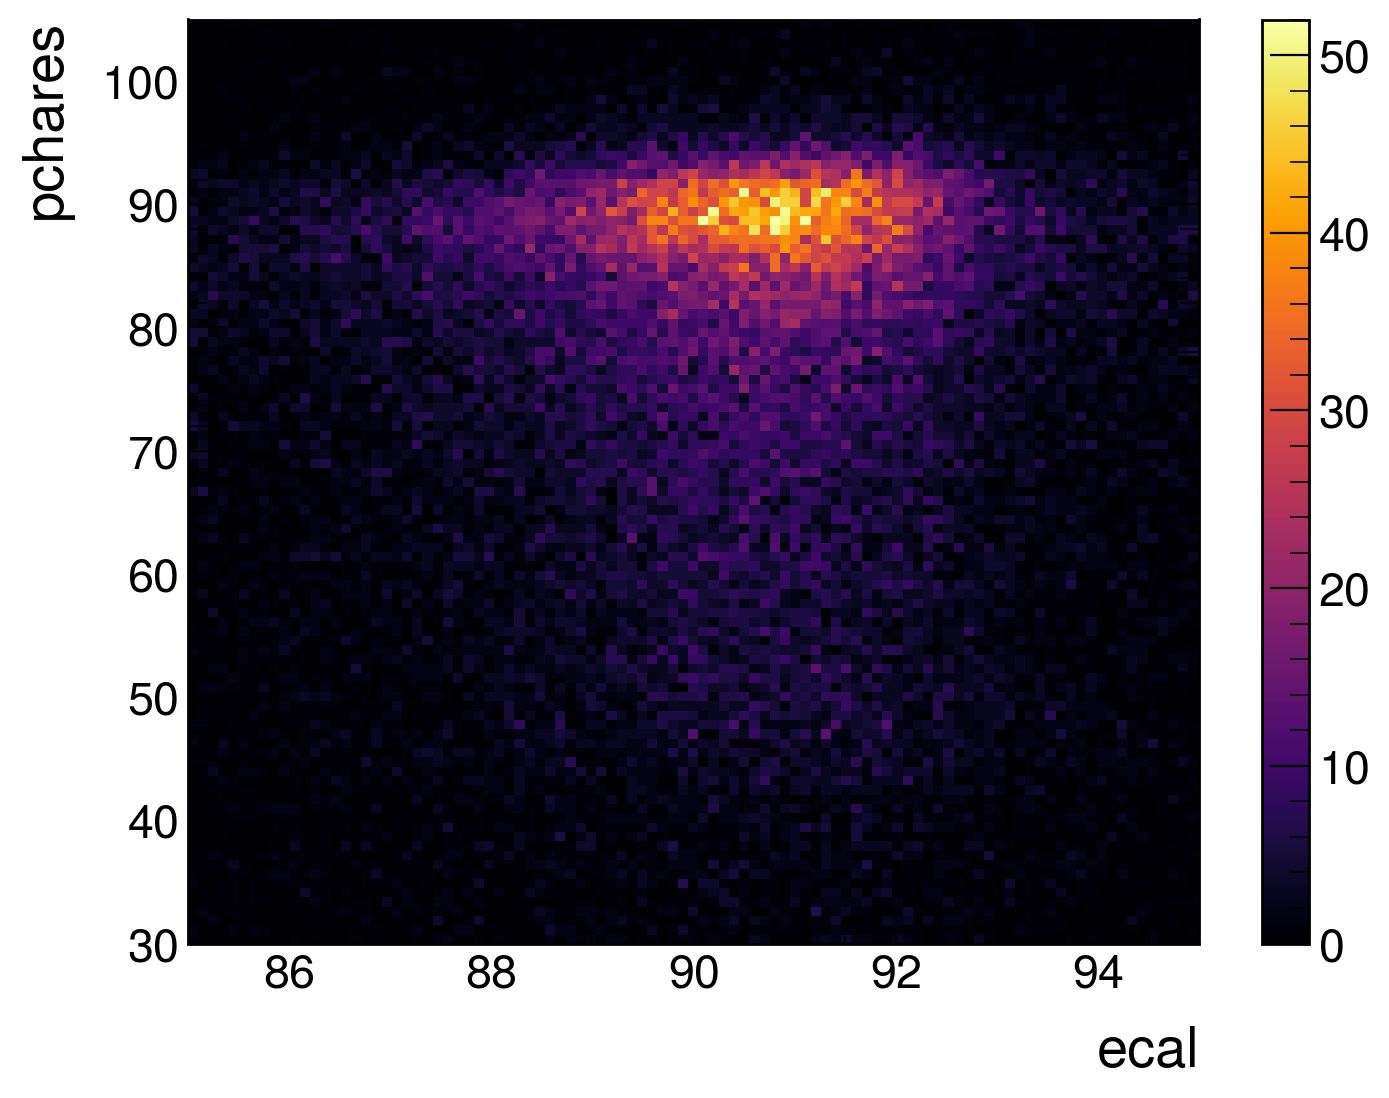

In [224]:
xedges = np.linspace(85,95,100)
yedges = np.linspace(30,105,100)
plt.hist2d(eecal[0],pchares[0], bins=(xedges, yedges),cmap = 'inferno')
plt.colorbar()
plt.xlabel('ecal')
plt.ylabel('pchares')
#plt.imshow(H)

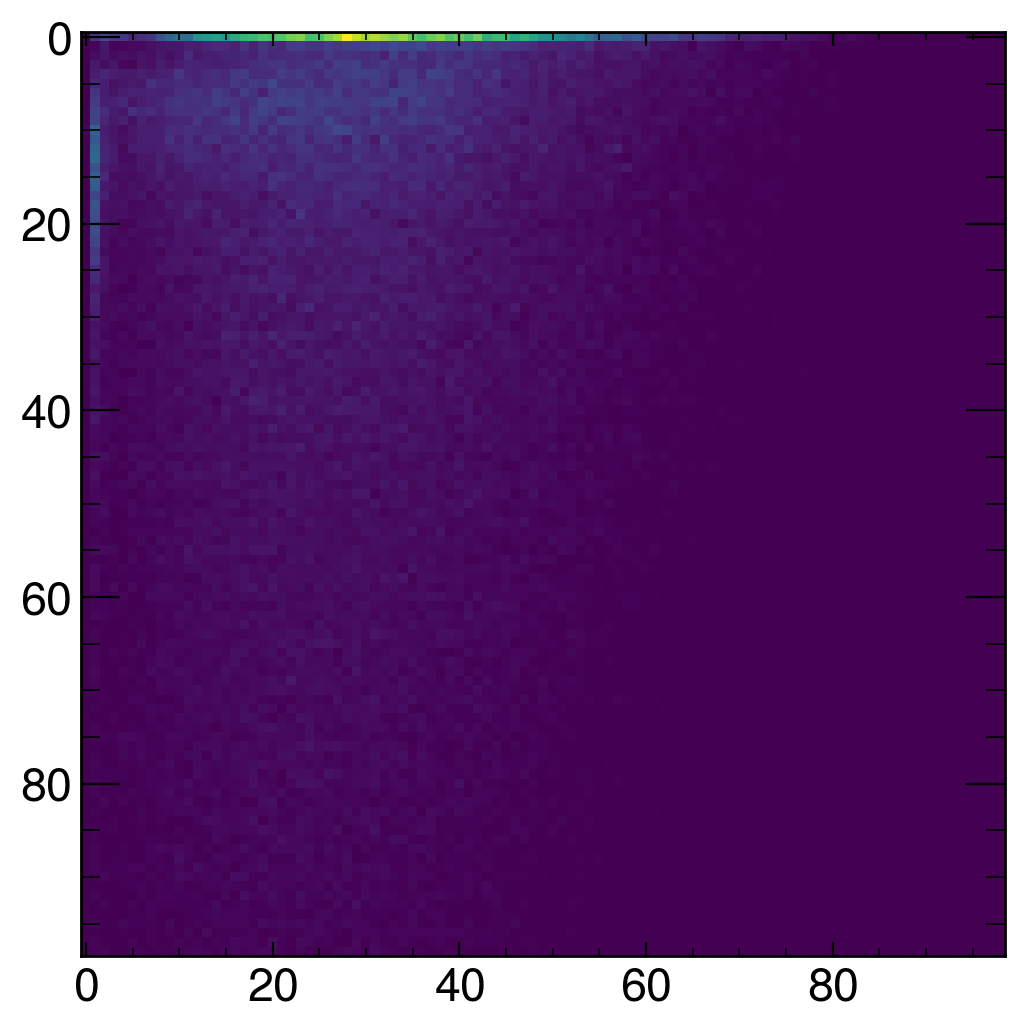

In [88]:
xedges = np.linspace(0,20,100)
yedges = np.linspace(0,100,100)
H, xedges, yedges = np.histogram2d(ehcal[2],eecal[2], bins=(xedges, yedges))
plt.imshow(H)

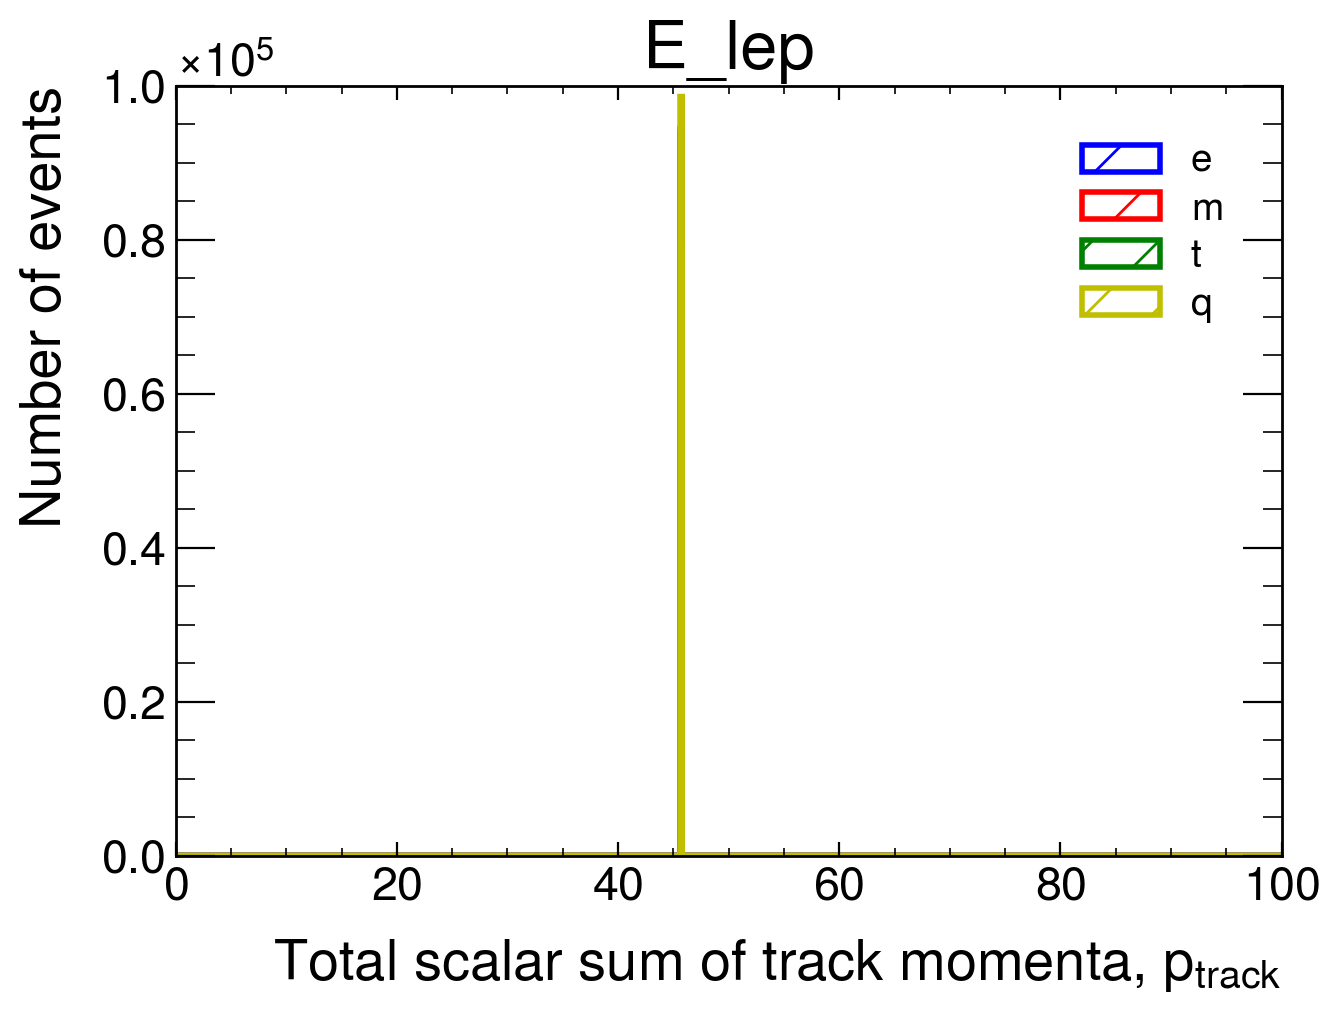

In [66]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(elep[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(elep[1], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(elep[2], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(elep[3], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[4])
plt.xlim(0.,100.)
plt.ylim(0,1e5)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

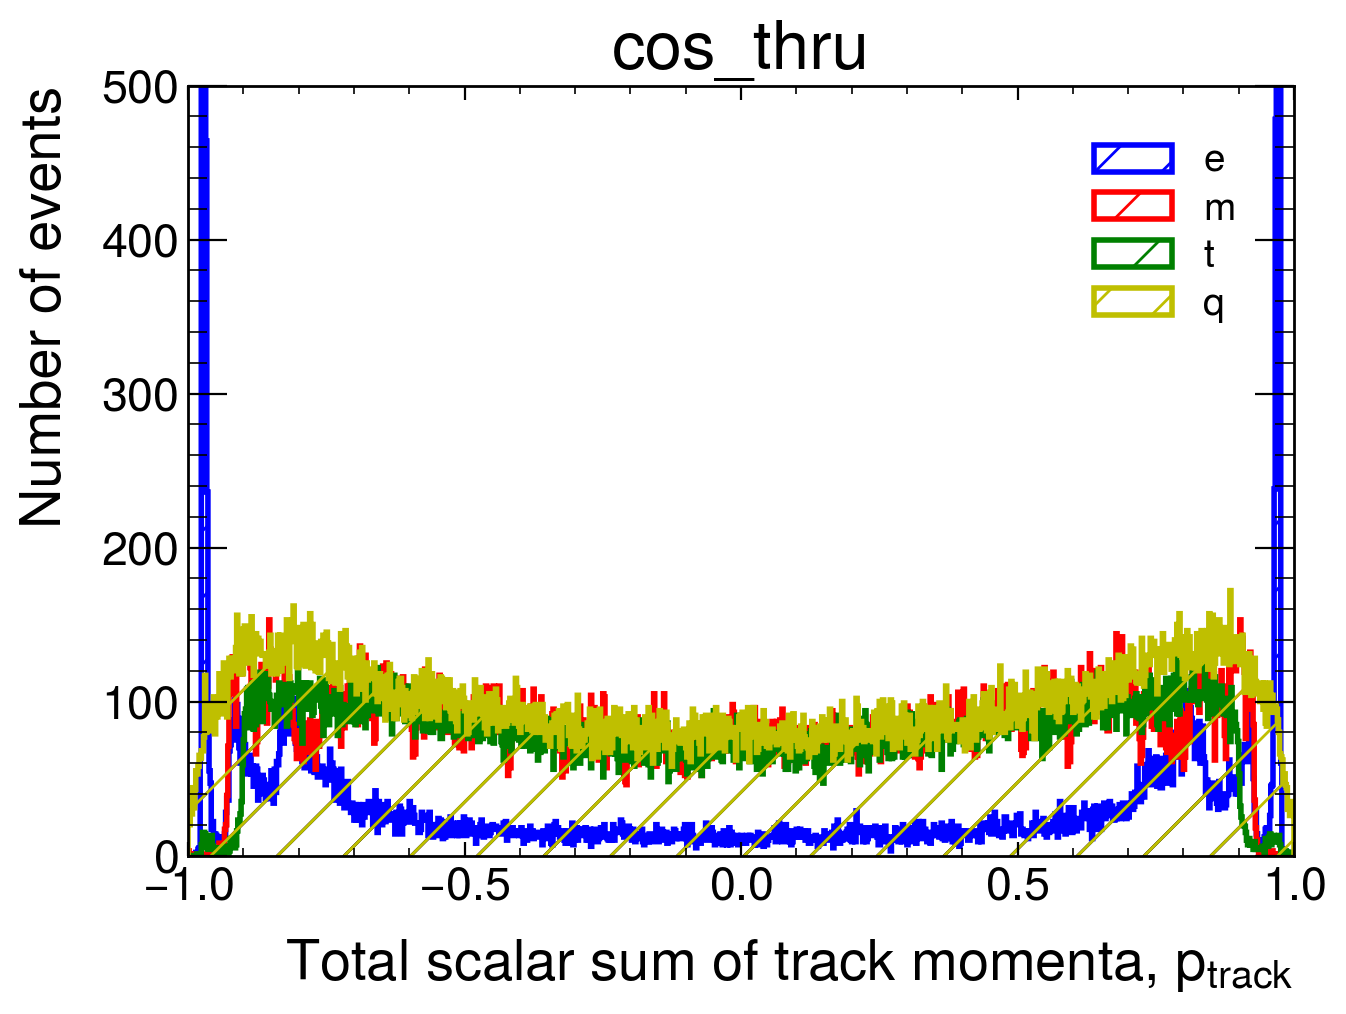

In [318]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(costhru[0], bins=1000, range=(-1,1.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(costhru[1], bins=1000, range=(-1,1.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(costhru[2], bins=1000, range=(-1,1.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(costhru[3], bins=1000, range=(-1,1.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')
#bin_content, bin_edges, _ = plt.hist(costhet[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[5])
plt.xlim(-1,1.)
plt.ylim(0,5e2)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

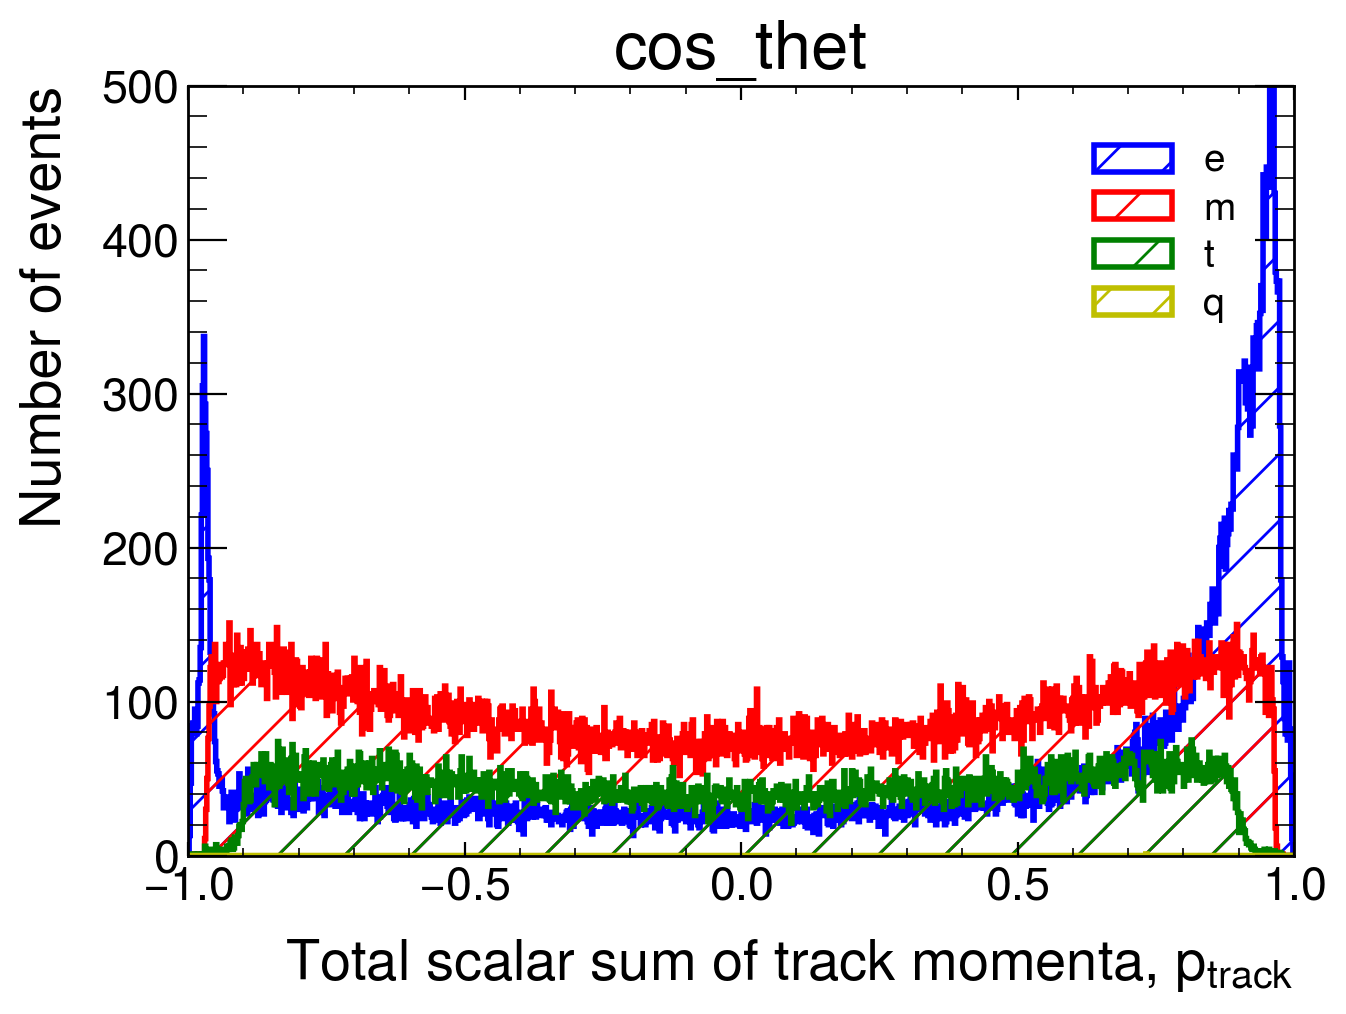

In [317]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(costhet[0], bins=1000, range=(-1,1.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(costhet[1], bins=1000, range=(-1,1.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(costhet[2], bins=1000, range=(-1,1.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(costhet[3], bins=1000, range=(-1,1.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')
#bin_content, bin_edges, _ = plt.hist(costhet[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[6])
plt.xlim(-1,1)
plt.ylim(0,5e2)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

In [245]:
from scipy.optimize import curve_fit

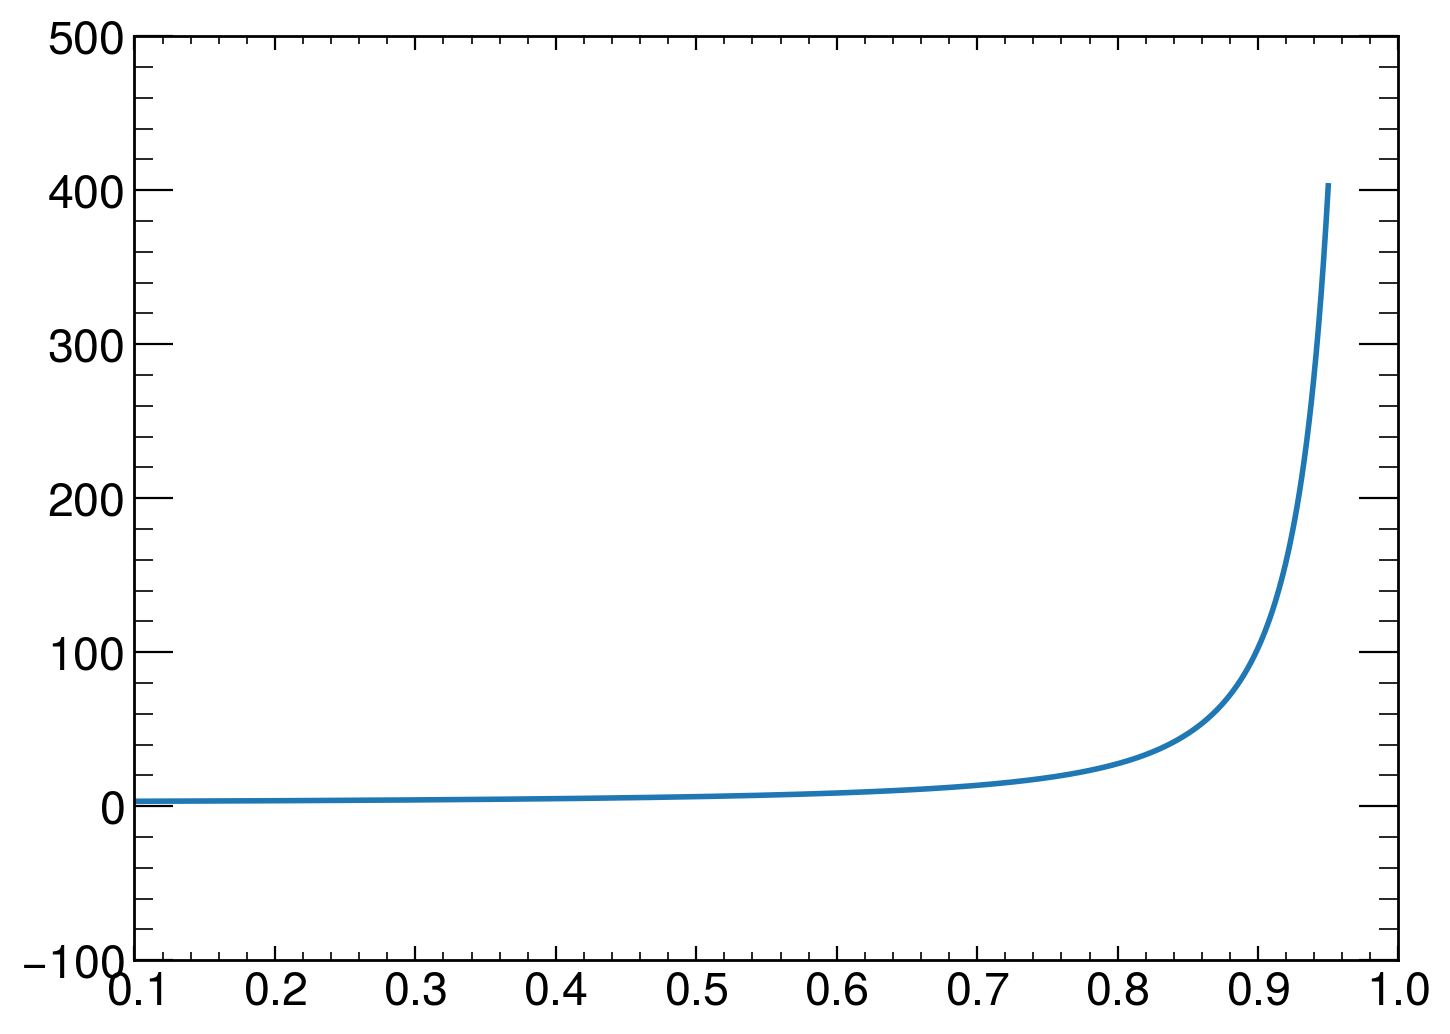

In [258]:
def dsigdtheta(theta,A,B,C):
    y = A*(1+theta**2)+B*(1-theta)**(-2)+C
    return y

theta = np.linspace(0.1,0.95,1000)
y = dsigdtheta(theta,1,1,1)
plt.plot(theta,y)

In [330]:
def cdsig(theta,A):
    return A*(1+theta**2)

[11.53610956  1.24202573 -0.49791424]


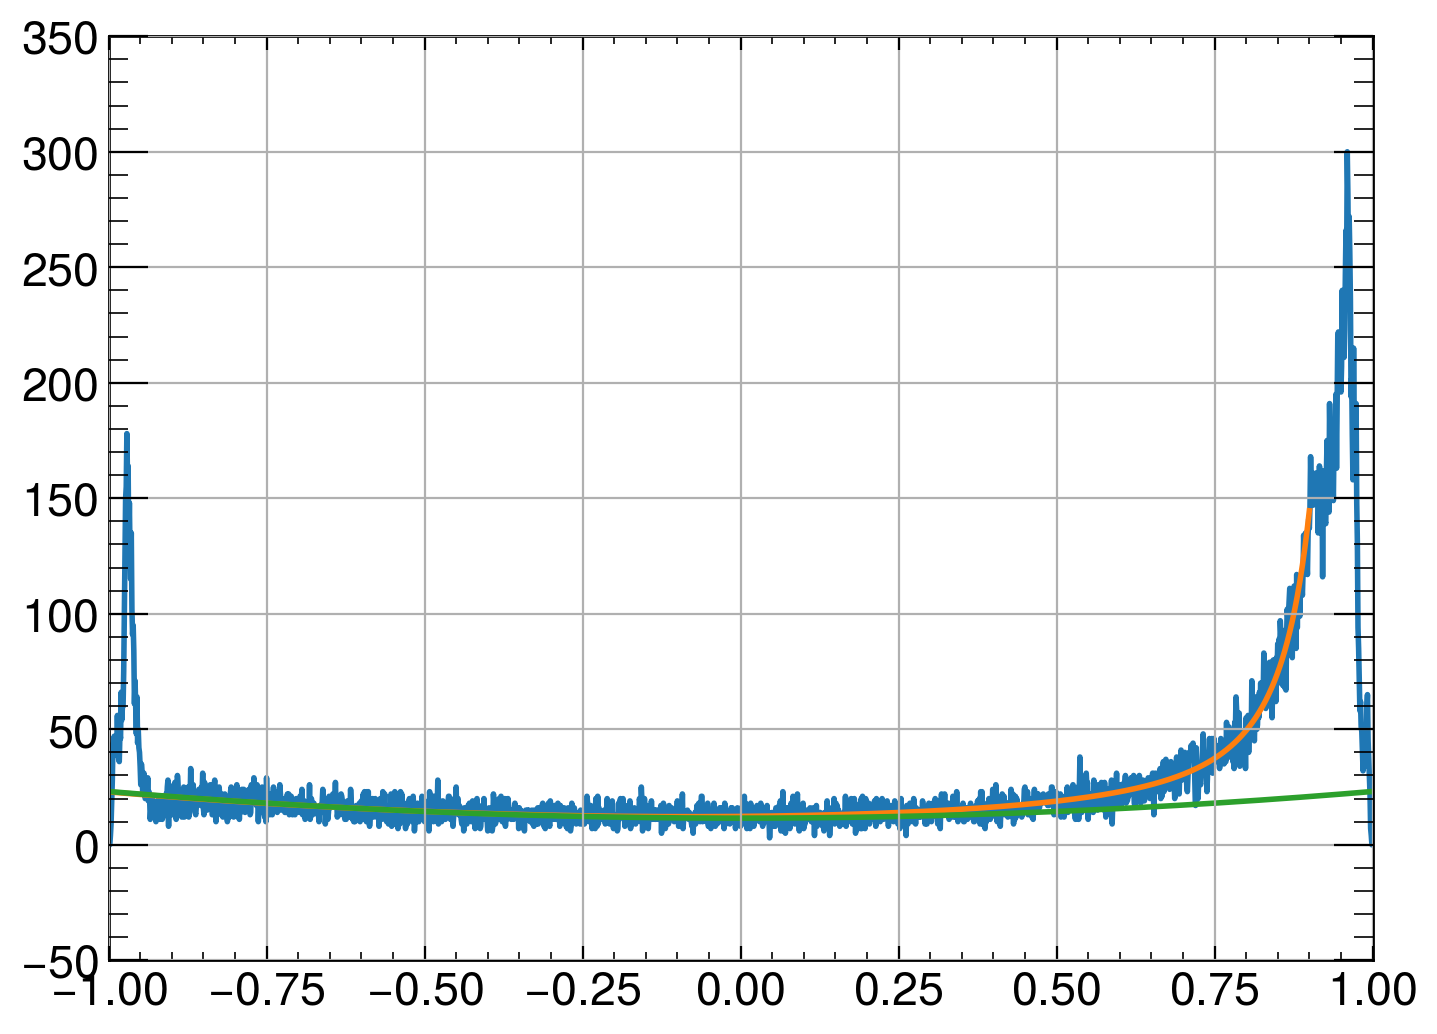

In [331]:
# Fit der Funktion an die Verteilung
# für elektronen an die Cos theta verteilung
y,x = np.histogram(costhet[0],bins = 2000, range = (-1,1))
x = x[1:]
y

coeff, var_matrix = curve_fit(dsigdtheta,x[100:1900], y[100:1900] )
hist_fit = dsigdtheta(x[0:1900],*coeff)
print(coeff)
plt.plot(x,y)
plt.grid()
plt.plot(x[:1900], hist_fit)
plt.plot(x,cdsig(x,coeff[0]))

# Test Cuts
## Searchig ee

In [204]:
emasks = [0] * 3
emasks[0] = brancheses[4]['E_ecal'] >= 50
emasks[1] = brancheses[4]['E_ecal'] >= 68
emasks[2] = brancheses[4]['Ncharged'] <= 6
emask = emasks[0] & emasks[1] & emasks[2]


mmasks = [0] * 3
mmasks[0] = brancheses[4]['E_ecal'] <= 50
mmasks[1] = brancheses[4]['Pcharged'] >= 75
mmasks[2] = brancheses[4]['Ncharged'] <= 6
mmask = mmasks[0] & mmasks[1] & mmasks[2]


tmasks = [0] * 3
tmasks[0] = brancheses[4]['E_ecal'] <= 65
tmasks[1] = brancheses[4]['Pcharged'] <= 70
tmasks[2] = brancheses[4]['Ncharged'] <= 6
tmask = tmasks[0] & tmasks[1] & tmasks[2]

qmasks = [0] * 3
qmasks[0] = brancheses[4]['Ncharged'] >= 6
qmasks[1] = brancheses[4]['Ncharged'] >= 6
qmasks[2] = brancheses[4]['Ncharged'] >= 6
qmask = qmasks[0] & qmasks[1] & qmasks[2]

[... True, True, True, True, True, True, False, True, False, True, True, True]]
[... False, False, True, False, False, False, False, False, False, False, False]]
[... False, False, False, False, False, False, False, False, False, False, False]]
[... False, False, False, False, False, False, False, False, False, False, False]]


<ipython-input-238-a13ef3bf99b5>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  n_content, bin_edges, _ = plt.hist(eecal[4][emask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='emask', zorder=2)


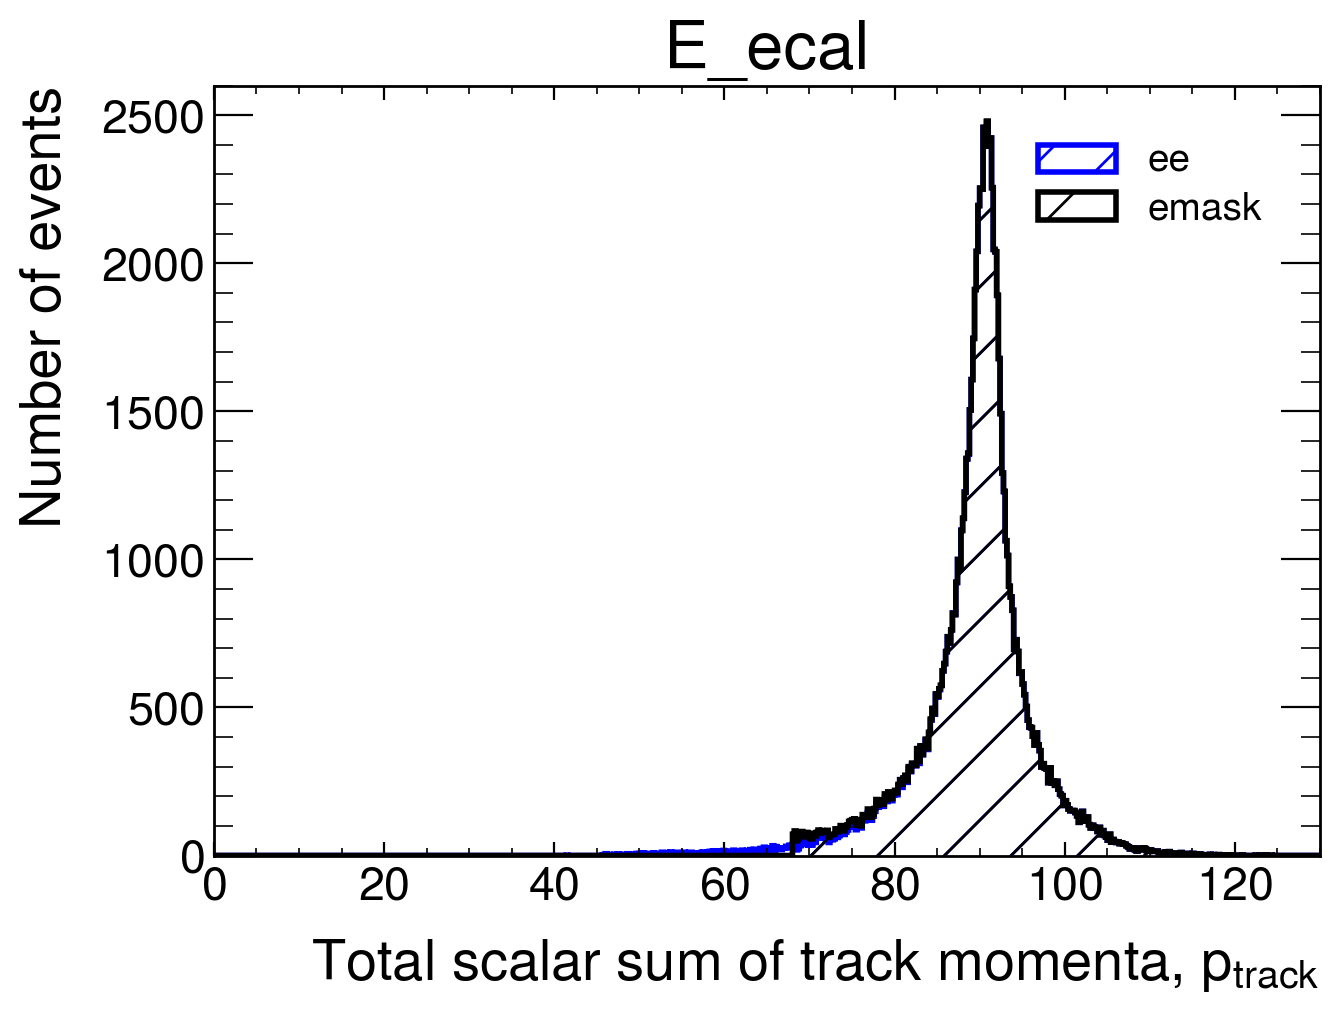

In [238]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(eecal[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='ee', zorder=1)
n_content, bin_edges, _ = plt.hist(eecal[4][emask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='emask', zorder=2)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[2])
plt.xlim(0.,130.)
plt.ylim(0,2.6e3)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

# Grope Data

In [396]:
G_runs = [0] * 5
G_events = [0] * 5
G_eleps = [0] * 5
G_nchares = [0] * 5
G_pchares = [0] * 5
G_eecals = [0] * 5
G_ehcals = [0] * 5

fs = ['ee', 'mm', 'tt', 'qq']

j = 0
while j < 4:
    eefile = open('opal_data/grope/'+fs[j]+'_ex.txt').read()
    eefile = eefile.split('\n')

    N = len(eefile) - 1
    #print(N)

    e_run = [0] * N
    e_event = [0] * N
    e_elep = [0] * N
    e_nchare = [0] * N
    e_pchare = [0] * N
    #e_ = [0] * N
    e_eecal = [0] * N
    #
    e_ehcal = [0] * N
    #

    for i in range(1,N):
        #print(j,i)
        if j == 0:
            line = eefile[i].split('\t')
            e_run[i] = float(line[0])
            e_event[i] = float(line[1])
            e_elep[i] = float(line[2])
            e_nchare[i] = float(line[3])
            e_pchare[i] = float(line[4])
            e_eecal[i] = float(line[6])
            e_ehcal[i] = float(line[8])
        else:
            line = eefile[i].split('\t')
            e_run[i] = float(line[0])
            e_event[i] =float(line[1])
            e_elep[i] = float(line[2])
            e_nchare[i] = float(line[3])
            
            try:
                e_pchare[i] = float(line[4])
            except:
                e_pchare[i] = 0
            try:
                e_eecal[i] = float(line[5])
            except:
                e_eecal[i] = 0
            e_ehcal[i] = float(line[6])
    
    G_runs[j] = e_run
    G_events[j] = e_event
    G_eleps[j] = e_elep
    G_nchares[j] = e_nchare
    G_pchares[j] = e_pchare
    G_eecals[j] = e_eecal
    G_ehcals[j] = e_ehcal
    
    j += 1

In [397]:
G_pchares[0]

[0,
 0.0,
 84.4,
 92.2,
 0.0,
 78.5,
 83.8,
 0.0,
 0.0,
 71.0,
 0.0,
 71.6,
 71.3,
 74.4,
 0.0,
 83.2,
 47.9,
 65.1,
 82.5,
 0.0,
 0.0,
 0.0,
 2.0,
 59.9,
 78.9,
 0.0,
 0.0,
 90.2,
 47.9,
 85.8,
 0.0,
 87.0,
 52.4,
 82.4,
 90.4,
 66.5,
 0.0,
 0.0,
 575.6,
 36.5,
 0.0,
 42.7,
 84.0,
 57.4,
 0.0,
 69.7,
 10.8,
 0.0,
 90.5,
 0.0,
 90.3]

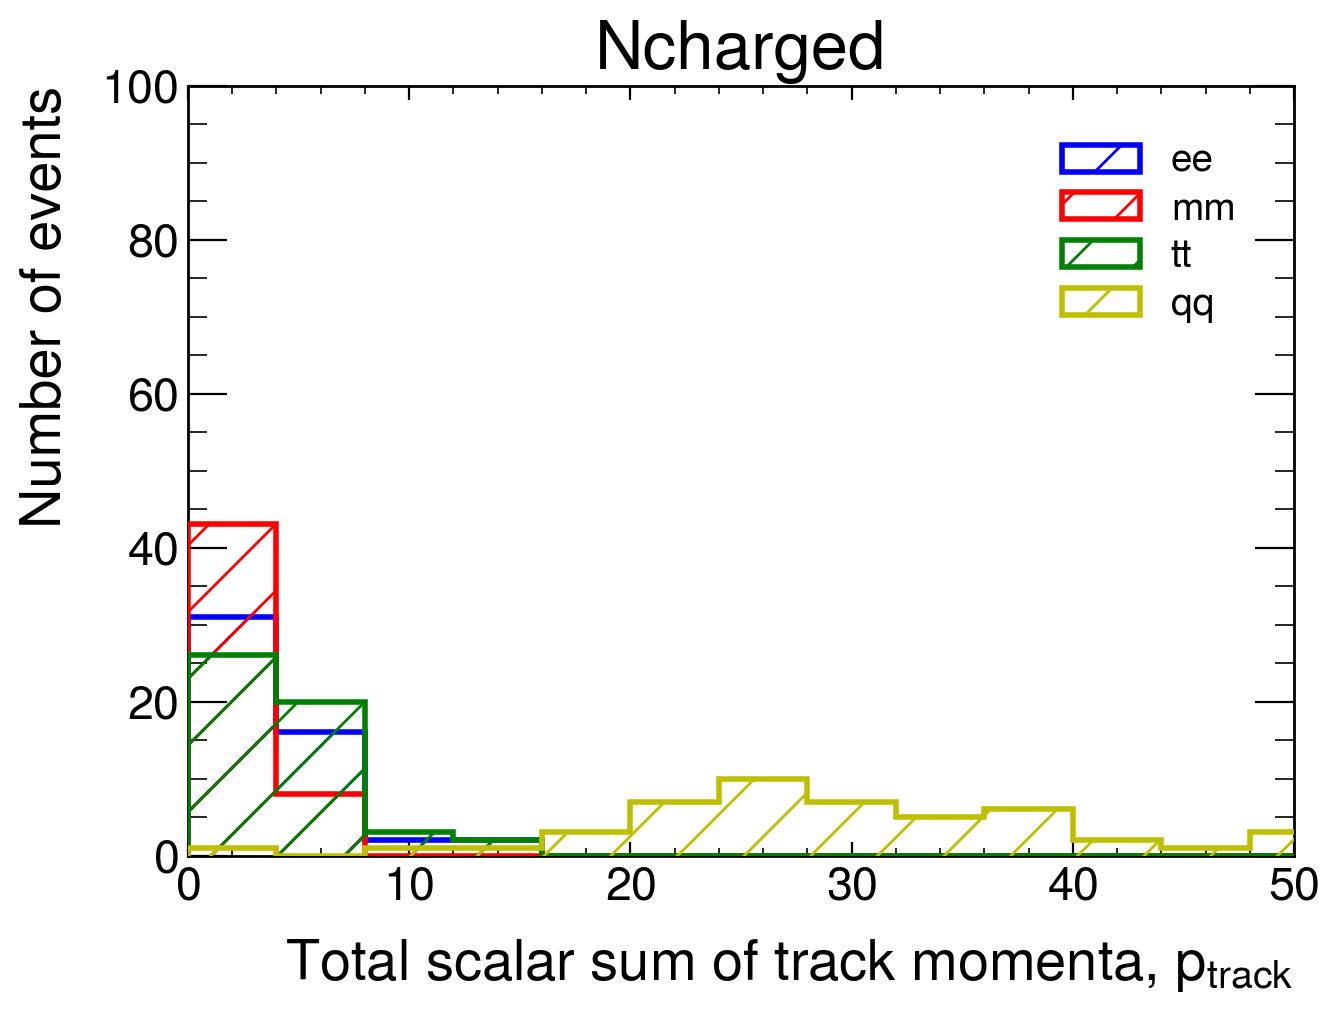

In [398]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(G_nchares[0], bins=25, range=(0.,100.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='ee', zorder=2)
bin_content, bin_edges, _ = plt.hist(G_nchares[1], bins=25, range=(0.,100.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='mm', zorder=3)
bin_content, bin_edges, _ = plt.hist(G_nchares[2], bins=25, range=(0.,100.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='tt', zorder=4)
bin_content, bin_edges, _ = plt.hist(G_nchares[3], bins=25, range=(0.,100.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='qq', zorder=5)
#bin_content, bin_edges, _ = plt.hist(G_nchares[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[0])
plt.xlim(0.,50)
plt.ylim(0,1e2)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

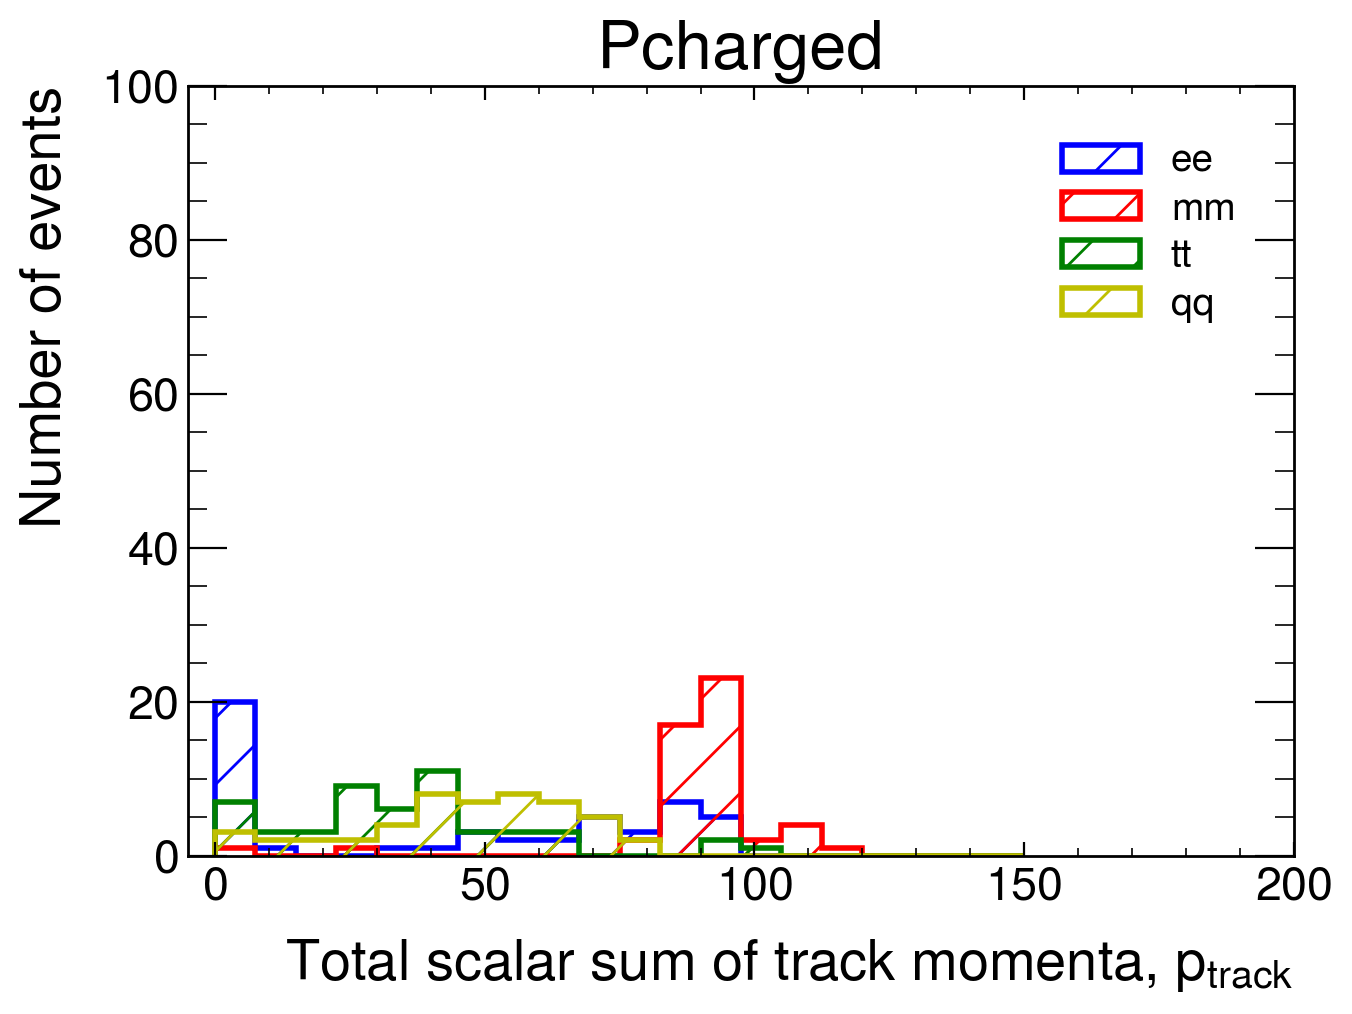

In [402]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(G_pchares[0], bins=20, range=(0.,150.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='ee')
bin_content, bin_edges, _ = plt.hist(G_pchares[1], bins=20, range=(0.,150.),histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='mm')
bin_content, bin_edges, _ = plt.hist(G_pchares[2], bins=20, range=(0.,150.),histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='tt')
bin_content, bin_edges, _ = plt.hist(G_pchares[3], bins=20, range=(0.,150.),histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='qq')
#bin_content, bin_edges, _ = plt.hist(G_pchares[4], bins=20, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


#mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

#error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[1])
plt.xlim(-5,200.)
plt.ylim(0,1e2)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

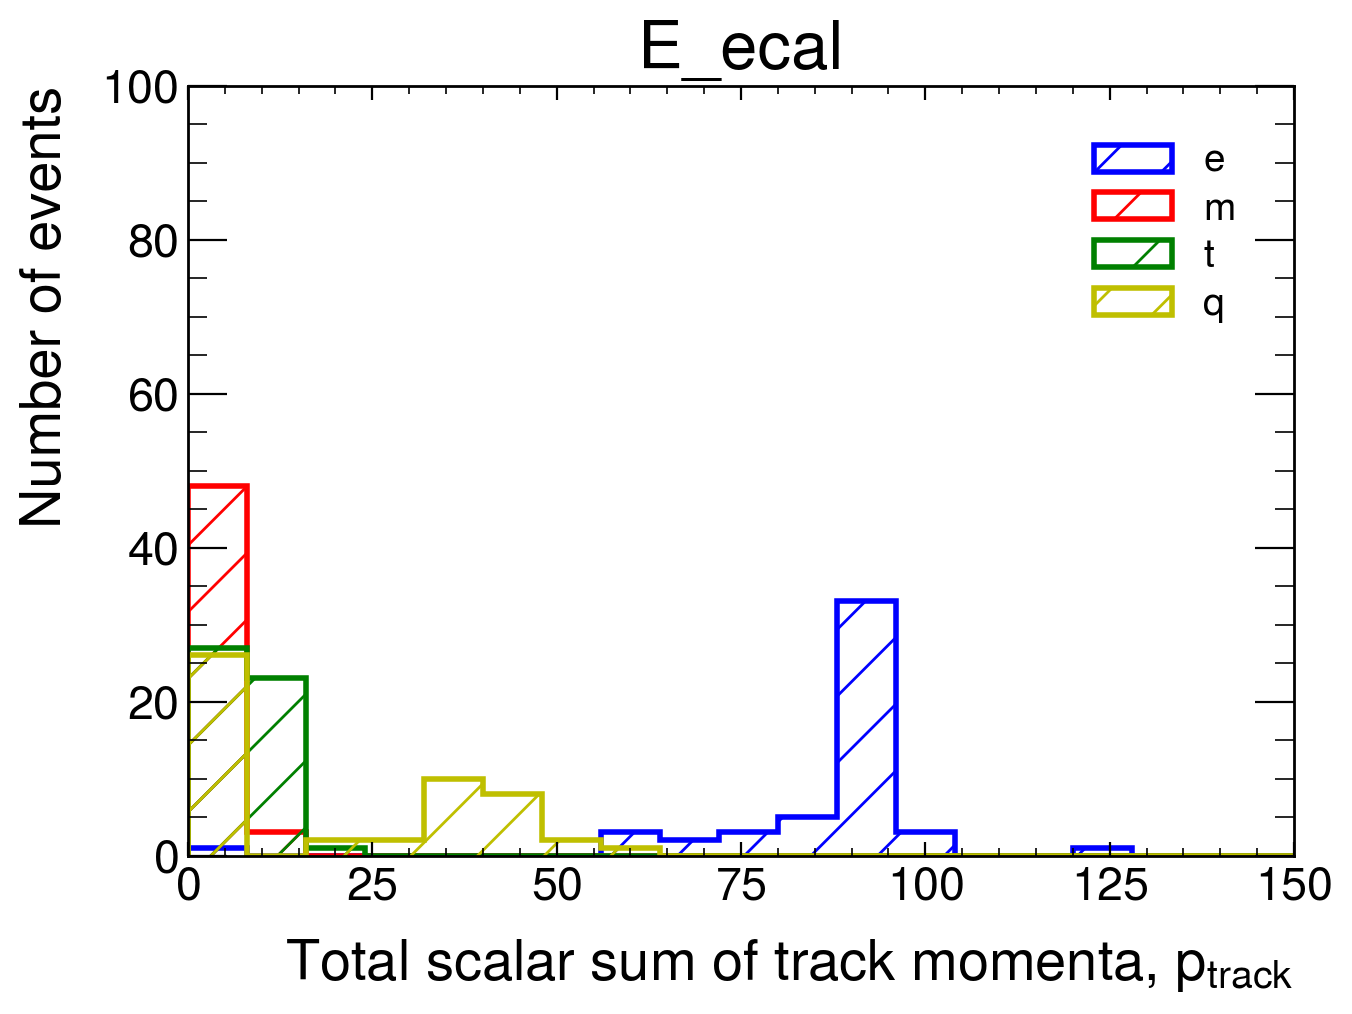

In [404]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(G_eecals[0], bins=25, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(G_eecals[1], bins=25, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(G_eecals[2], bins=25, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(G_eecals[3], bins=25, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')
#bin_content, bin_edges, _ = plt.hist(G_eecal[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


#mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

#error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[2])
plt.xlim(0.,150.)
plt.ylim(0,1e2)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

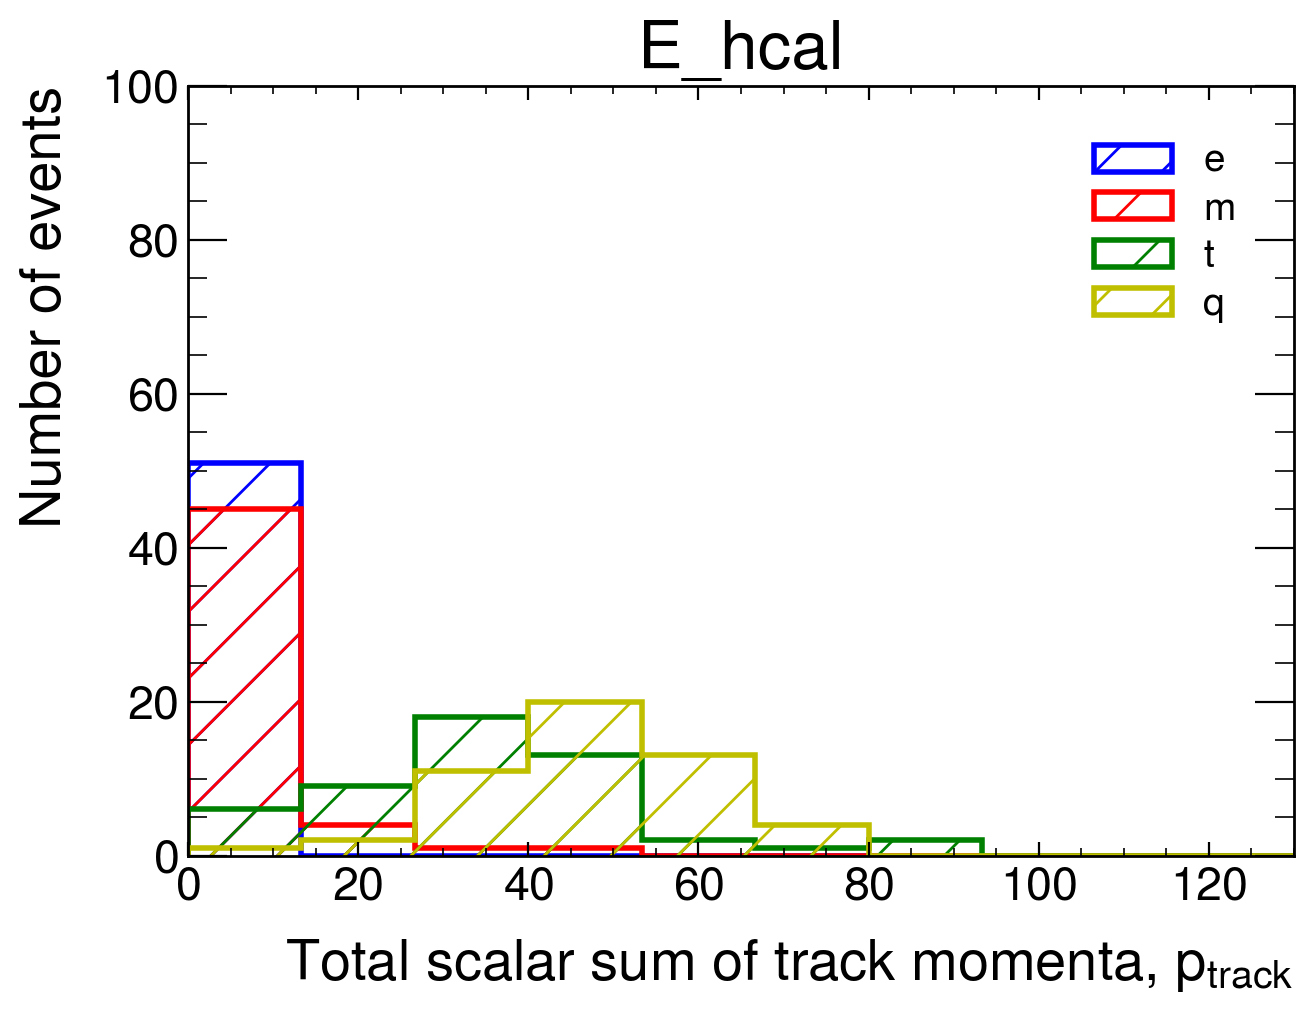

In [401]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(G_ehcals[0], bins=15, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(G_ehcals[1], bins=15, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(G_ehcals[2], bins=15, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(G_ehcals[3], bins=15, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')
#bin_content, bin_edges, _ = plt.hist(G_ehcals[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[3])
plt.xlim(0.,130)
plt.ylim(0,1e2)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

### Statistical uncertainties to the histogram

Think about the statistical uncertainties computed above in 'error_sizes'. 
* **Are these sensible? Why do we use this formula?** (Hint: Making an histogram is, in short, a *counting experiment*. In the limit of large total number of events, the (binomial) probability function limits to the *Poisson distribution*. What is the variance? And the standard deviation?)

### *Example*: How to fit a distribution

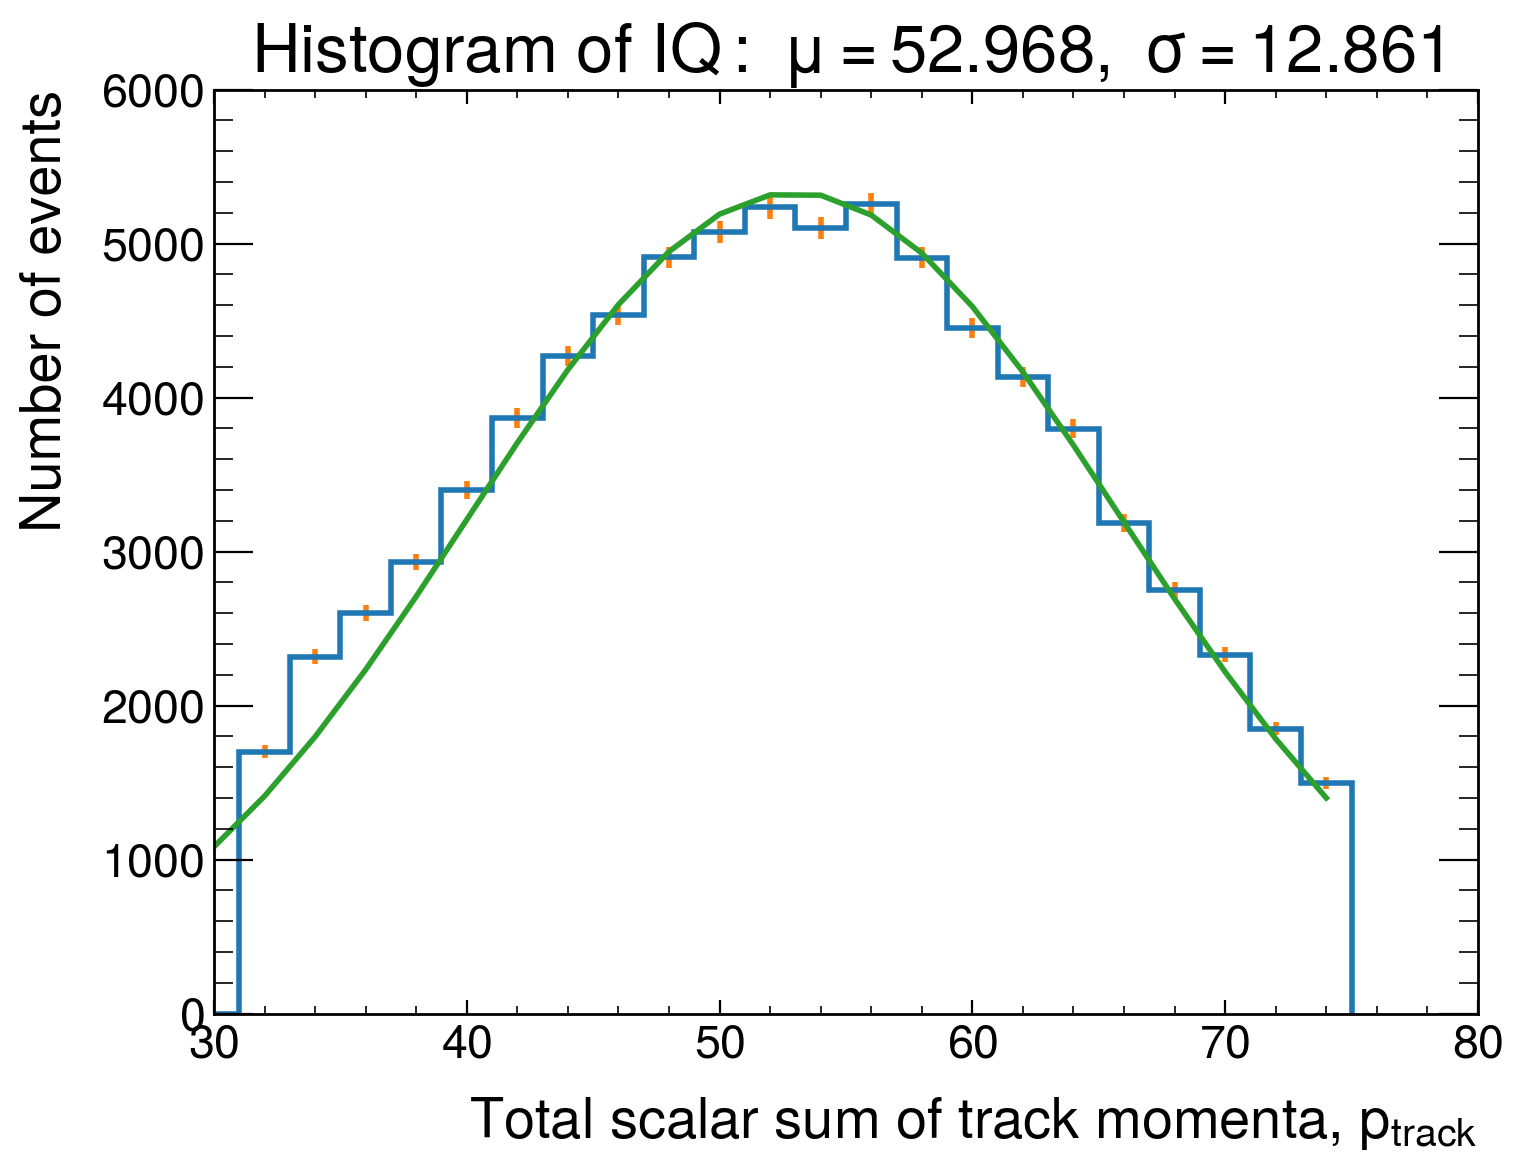

In [8]:
from scipy.optimize import curve_fit

mynewmask = branches['Pcharged'] >= 31.23

# Plot data with statistical uncertainties
new_bin_content, new_bin_edges, _ = plt.hist(pchar[mynewmask],bins=25,range=(25.,75.),  histtype='step', linewidth=2, label='Pcharged')
new_mid = 0.5*(new_bin_edges[1:] + new_bin_edges[:-1]) #Calculate midpoint of the bars
new_error_sizes = np.sqrt(new_bin_content)

plt.errorbar(new_mid, new_bin_content, yerr=new_error_sizes, fmt='none')

### Show the plot on screen
plt.title('My title')
plt.xlim(30.,80.)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')


# Define model function to be used to fit to the data above:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [321., 50., 32.]

## Fit curve (WARNING: The fit does not propagate bin uncertainties to the uncertainties of the fit parameters!)
coeff, var_matrix = curve_fit(gauss, new_mid, new_bin_content, p0=p0)

# Get the fitted curve
hist_fit = gauss(new_mid, *coeff)

plt.plot(new_mid, hist_fit, label='Fit')

plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(coeff[1], abs(coeff[2])))

plt.show()

### Matrix Inversion
To determine the uncertainties of the matrix elements after the inversion we use Monte Carlo toy experiments. In this context, what are the advantages and disadvantages of this method when compared to analytical expressions? Discuss it briefly.

**References**:
* Propagation of Errors for Matrix Inversion: https://arxiv.org/abs/hep-ex/9909031v1

Erros for the inverse matrix:
[[0.01703261 0.00010217 0.00010217 0.00010217]
 [0.00010217 0.01703261 0.00010217 0.00010217]
 [0.00010217 0.00010217 0.01703261 0.00010217]
 [0.00010217 0.00010217 0.00010217 0.01703261]]


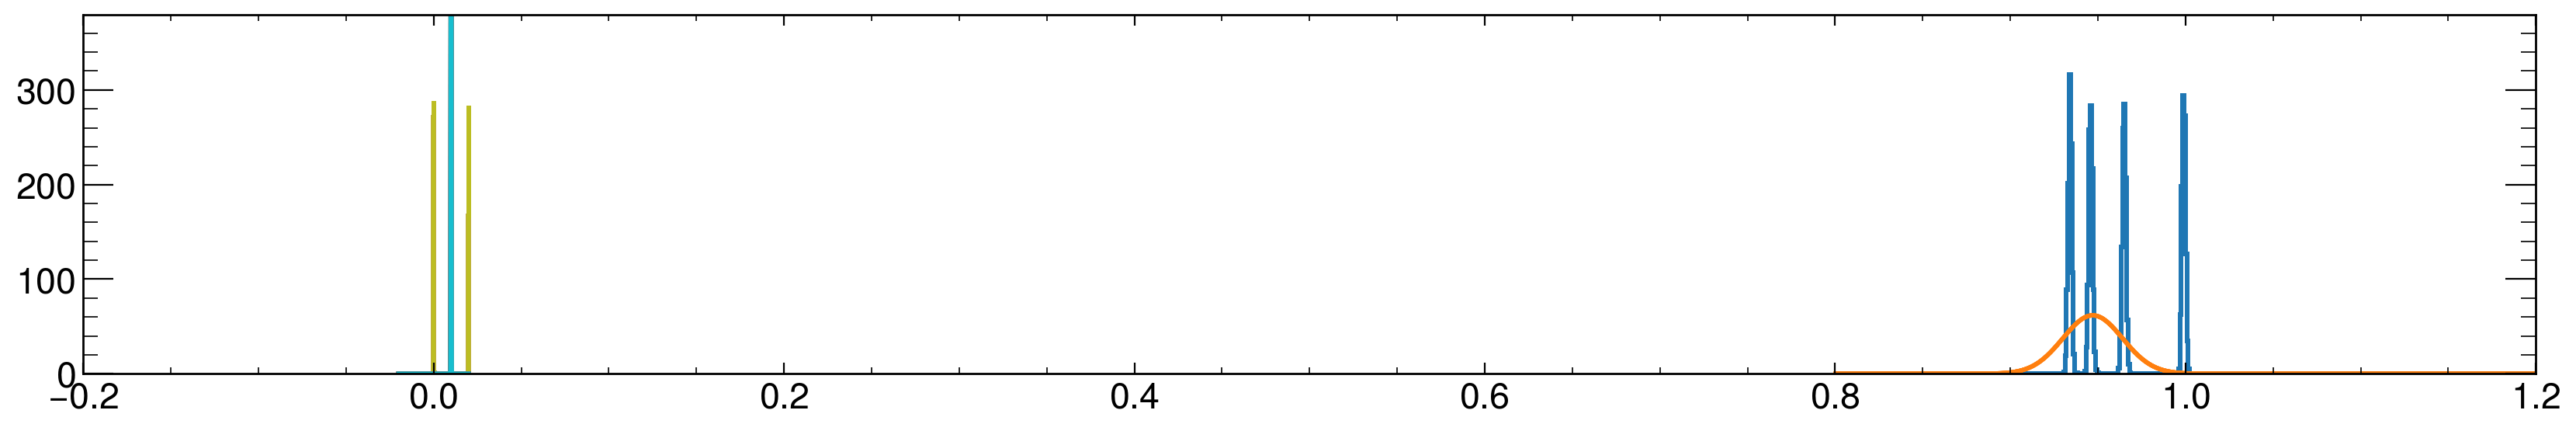

In [9]:
matrix = np.array([[0.934, 0.02,  0.01, 0.],
                  [0.01,  0.946, 0.01, 0.01],
                  [0.01,  0.01,  0.965,0.01],
                  [0.01,  0.01,  0.01, 0.999]])

error_matrix = np.array([[0.001,   0.0001,  0.0001, 0.0001],
                        [0.0001,  0.001,   0.0001, 0.0001],
                        [0.0001,  0.0001,  0.001,  0.0001],
                        [0.0001,  0.0001,  0.0001, 0.001]])

### Number of toy experiments to be done
ntoy = 1000

### Create numpy matrix of list to append elements of inverted toy matrices
inverse_toys = np.empty((4,4),dtype=object)
inverse_toys.fill([])

# Create toy efficiency matrix out of gaussian-distributed random values
for i in range(0,ntoy,1):
    toy_matrix = np.zeros((4,4))
    toy_matrix = np.random.normal(matrix,error_matrix,size=(4,4))

    ### Invert toy matrix
    inverse_toy = np.linalg.inv(toy_matrix)
    
    # Append values
    for j in range(0,4,1):
        for k in range(0,4,1):
            inverse_toys.item(j,k).append(toy_matrix.item(j,k))
    
# Define gaussian function to fit to the toy distributions:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

inverse_errors = np.zeros((4,4))
inverse_means = np.zeros((4,4))

plt.figure(figsize=(20, 3))

# Fill histograms for each inverted matrix coefficient:
for j in range(0,4,1):
    for k in range(0,4,1):
        
        # Diagonal and off-diagonal terms have different histogram ranges
        rmin = 0. ; rmax = 0.
        if j==k: 
            rmin = 0.8 ; rmax = 1.2
        else:
            rmin = -0.02 ; rmax = 0.02
        
        hbins, hedges, _ = plt.hist(inverse_toys.item(j,k),bins=500,range=(rmin,rmax),  histtype='step', linewidth=2, label=f'toyhist{j}{k}')
        plt.ylim(0.,1.2*max(hbins))


        # Get the fitted curve
        h_mid = 0.5*(hedges[1:] + hedges[:-1]) #Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins)
        h_fit = gauss(h_mid, *coeffs)
        
        plt.plot(h_mid, h_fit,label=f'Fit{j}{k}')

        inverse_means[j,k] = coeffs[1]
        inverse_errors[j,k] = abs(coeffs[2])

print(f"Erros for the inverse matrix:\n{inverse_errors}")

# Exercise 2: Separate $t$- and $s$-channel contributions

Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The **electron** Monte Carlo sample incorporate contributions from $t$- and $s$-channels.
* Select/correct contributions producing $Z$ boson decays. (Hint: Which role does the $\cos(\theta)$ distribution play in separating $t$- and $s$-channels?)

# Exercise 3: Measurement of the total production cross sections

For **each** of the seven centre-of-mass energies:
* Determine the number of events in the handronic channel *and* in the three leptonic channels
* Substract the background and correct for selection efficiencies accordingly
* Then, calculate the differnetial cross sections for the hadronic *and* the leptnic channels
* Add the radiation corrections from The table given below. **Don't forget to take the uncertainties (errors) into account!**

| $\sqrt{s}$   \[GeV\]| Correction hadronic channel    \[nb\] |  Correction leptonic channel   \[nb\]|
| --- | --- | --- |
| 88.47 | +2.0  | +0.09 |
| 89.46 | +4.3  | +0.20 |
| 90.22 | +7.7  | +0.36 |
| 91.22 | +10.8 | +0.52 |
| 91.97 | +4.7  | +0.22 |
| 92.96 | -0.2  | -0.01 |
| 93.76 | -1.6  | -0.08 |

Feel free to access these values using the dictionary 'xs_corrections' given below.
* Once the total cross section for all four decay channels at all seven energies have been measured, fit a **Breit-Wigner distribution** to measure the $Z$ boson mass ($m_Z$) and the resonance width ($\Gamma_Z$) and the peak cross section s of the resonance for the hadronic and the leptonic channels. Again, **propagate the uncertainties carefully**.
* Compare your results to the OPAL cross section s and the theoretical predictions. How many degrees of freedom does the fit have? How can you udge if the model is compatible with the measured data? Calculate the  **confidence levels**.
* Calculate the partial widths for all channels from the measured cross sections on the peak. Which is the best partial width to start with? Compare them with the theoretical predictions and the values that you have calculated in the beginning.
* Determine from your results the **number of generations of light neutrinos**. Which assumptions are necessary?
* Discuss in detail the systematic uncertainties in the whole procedure of the analysis. Which assumptions were necessary?

These are some **references** that might be interesting to look up:
* Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf
** Resonances: https://pdg.lbl.gov/2017/reviews/rpp2017-rev-resonances.pdf
* Precision Electroweak Measurements on the Z Resonance (Combination LEP): https://arxiv.org/abs/hep-ex/0509008
* Measurement of the $Z^0$ mass and width with the OPAL detector at LEP: https://doi.org/10.1016/0370-2693(89)90705-3
* Measurement of the $Z^0$ line shape parameters and the electroweak couplings of charged leptons: https://inspirehep.net/literature/315269
* The OPAL Collaboration, *Precise Determination of the $Z$ Resonance Parameters at LEP: "Zedometry"*: https://arxiv.org/abs/hep-ex/0012018
* Fitting a Breit-Wigner curve using uproot: https://masonproffitt.github.io/uproot-tutorial/07-fitting/index.html

In [10]:
xs_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                      'hadronic' : [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6],
                      'leptonic' : [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]}

# Exercise 3: Forward-backward asymmetry and $\sin^2(\theta_\text{W})$ in muon final states

* Using the **muon channel only**, measure the forward-backward asymmetry $\mathcal{A}_\text{FB}$ using OPAL data and muon Monte Carlo events. Take into account the radiation corrections given below. 

| $\sqrt{s}$   \[GeV\]| Radiation correction [-]|  
| --- | --- | 
| 88.47 | 0.021512  | 
| 89.46 | 0.019262  | 
| 90.22 | 0.016713  | 
| 91.22 | 0.018293  | 
| 91.97 | 0.030286  | 
| 92.96 | 0.062196  | 
| 93.76 | 0.093850  | 

Feel free to use the dictionary 'radiation_corrections' given below.

* Measure the **Weinberg angle** as $\sin^2(\theta_\text{W})$. Compare the measurement with the literature.

In [11]:
radiation_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                          'correction' : [0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]}

# Exercise 4: Tests on lepton universality¶

* Test the lepton universality from the total cross sectinos on the peak for $Z\to e^+ e^-$, $Z\to \mu^+ \mu^-$ and $Z\to \tau^+ \tau^-$ events. What is the ratio of the total cross section of the hadronic channel to the leptonic channels on the peak? Compare with the ratios obtained from the branching rations and discuss possible differences.

In [0]:
datadata